<a href="https://colab.research.google.com/github/momowade221/Notebook_Segmentation_Client_OM/blob/master/OM_Segmentation_client_OM_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONFIGURATION**

---



In [ ]:
!pip install pyspark
# !pip install squarify
# !pip install lifetimes
# !pip install kmodes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=c4ffa4971bcf1ab7ed551785efad10c41d964d8d1d3397420dc8ffa709f04c75
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/Colab/Segmentation/
myPath='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *
from pyspark.ml.feature import *
from pyspark.ml import *
from pyspark.ml.clustering import *
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.column import Column


import sklearn
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

spark = SparkSession.builder.appName("Transactions_OM").getOrCreate()

# Configuration pour permettre l'analyse des dates au format Legacy
# spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark


Mounted at /content/drive
/content/drive/MyDrive/Colab/Segmentation


# **PRÉPARATION DES DONNÉES**

---



## **Collection des données**

In [ ]:
def df_load(path):
    # Charger le DataFrame depuis le fichier CSV avec les colonnes existantes
    df_loaded= spark.read.csv(f'{path}', header=True)
    # BaseTransaction OM - Renommer les colonnes
    #new_column_names = [col_name.replace(f"{table}.", "") for col_name in df_loaded.columns]
    #df_loaded = df_loaded.toDF(*new_column_names)
    return df_loaded

def pd_load(path):
    # Charger le DataFrame depuis le fichier CSV avec les colonnes existantes
    pd_loaded = pd.read_csv(path)
    # Renommer les colonnes
    # pd_loaded.columns = [col.replace(f"{table}.", "") for col in pd_loaded.columns]
    return pd_loaded

# SICO
df_sico=df_load(f'{myPath}/segmentation_sico.csv')
# pd_sico = pd_load(f'{myPath}/segmentation_sico.csv')

# Segmentation
df_roaming=df_load(f'{myPath}/segmentation_multi_sim.csv')
pd_roaming=pd_load(f'{myPath}/segmentation_multi_sim.csv')

df_segment_rfm=df_load(f'{myPath}/segmentation_valeur_rfm.csv').drop("score_R","score_F","score_M")
pd_segment_rfm=pd_load(f'{myPath}/segmentation_valeur_rfm.csv').drop(["score_R","score_F","score_M"], axis=1)

df_kmeans_encoded_loaded=df_load(f'{myPath}/dataset_kmeans_encoded.csv')
pd_kmeans_encoded_loaded=pd_load(f'{myPath}/dataset_kmeans_encoded.csv')

#Localisaion
df_location_night=df_load(f'{myPath}/vente_rebond_location_night.csv')
#pd_localisation=pd_load(f'{myPath}/vente_rebond_location_night.csv')

df_recharge=df_load(f'{myPath}/vente_rebond_recharge_in_details.csv')
df_segmentation_client=df_load(f'{myPath}/segmentation_client.csv')
# #Redefined reporting
# df_segment_recharge=df_load(f'{myPath}/segmentation_recharge_segment.csv')
# pd_segment_recharge=pd_load(f'{myPath}/segmentation_recharge_segment.csv')

# OM
df_transaction_om=df_load(f'{myPath}/segmentation_base_transaction_om.csv')
# pd_transaction_om = pd_load(f'{myPath}/segmentation_base_transaction_om.csv'

df_kmeans_init_loaded=df_load(f'{myPath}/dataset_kmeans_initial.csv')
pd_kmeans_init_loaded=pd_load(f'{myPath}/dataset_kmeans_initial.csv')



<ipython-input-3-235ee3da5422>:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_loaded = pd.read_csv(path)
<ipython-input-3-235ee3da5422>:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_loaded = pd.read_csv(path)


In [ ]:
df_segment_multisim_loaded=df_load(f'{myPath}/segment_multisim_created.csv')
pd_segment_multisim_loaded=pd_load(f'{myPath}/segment_multisim_created.csv')
pd_segment_multisim_loaded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345995 entries, 0 to 345994
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   caller_msisdn             345995 non-null  int64  
 1   segment_sim               345995 non-null  object 
 2   anciennete                335837 non-null  float64
 3   age                       305812 non-null  float64
 4   ca_cr_commune             317974 non-null  object 
 5   statut_client_om          345995 non-null  object 
 6   segment_RFM               100347 non-null  object 
 7   moyenne_montant_recharge  194073 non-null  float64
 8   segment_recharge          339824 non-null  object 
 9   segment_marche            339824 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 26.4+ MB


## **Exploration**

### Définition des fonctions d'exploration

In [ ]:
def df_info(df: DataFrame):
   # Informations sur le schéma du DataFrame
   ############ Info ###########")
   print(f"Nombre de features: {len(df.columns)}")
   df.printSchema()

   # Noms des colonnes
   ############ Colonnes ###########")
   print(df.columns)

   # Dimensions (nombre de lignes et de colonnes)
   ############ Dimensions ###########")
   num_rows = df.count()
   num_cols = len(df.columns)
   print(f"\n \n  Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

   # Afficher les premières lignes (les 5 premières lignes sans troncature)
   ############ Premières lignes ###########")
   df.show(5, truncate=False)  # Affiche les 5 premières lignes sans troncature

   # Afficher les dernières lignes (les 5 dernières lignes triées par la première colonne en ordre décroissant)
   print("\n########### Dernières lignes ###########")
   df.orderBy(df.columns[0], ascending=False).show(5, truncate=False)  # Affiche les 5 dernières lignes

   # Statistiques sommaires (quantiles) du DataFram
   print("\n########### Statistiques sommaires ###########")
   df.summary().show()


def df_info_detailed(df:DataFrame):
  df_info(df)

  # Données manquantes (NA)
  print("\n########### Données manquantes ###########")
  # Compter le nombre de valeurs manquantes (NA) par colonne
  count_NA = df.agg(*[sum(df[c].isNull().cast("int")).alias(c) for c in df.columns])
  # Afficher le résultat
  print("Le nombre de colonnes qui contiennent des valeurs manquantes (NA)")
  count_NA.show()

  # Compter les occurrences de "NULL" dans chaque colonne
  count_exprs = [expr(f"sum(case when {c} like '%NULL%' then 1 else 0 end) as {c}_count") for c in df.columns]
  print("Le nombre de lignes qui contiennent la chaîne 'NULL'")
  count_NULL = df.select(*count_exprs)
  count_NULL.show()

  # Données dupliquées
  print("\n########### Données dupliquées ###########")

  # Find rows where all column values are identical
  duplicate_rows=df.groupBy(*df.columns).agg(count("*").alias("count"))
  duplicate_rows = duplicate_rows.filter(duplicate_rows["count"] > 1).select(*df.columns)

  if duplicate_rows.count()==0:
    print("Aucune ligne dupliquée trouvée")
  else:
    print(f"Nombre de données dupliquées : {duplicate_rows.count()}")
    # Show the rows with identical value
    duplicate_rows.show()

#Fonction pour afficher un DataFrame PySpark sous forme de Pandas DataFrame
def printdf(df):
    return df.toPandas()


In [ ]:
import pandas as pd

# Fonction pour afficher des informations sur un DataFrame Pandas
def df_info_pandas(df):

    # Informations sur le schéma du DataFrame
    print("########### Info ###########")
    print(df.dtypes)

    # Noms des colonnes
    print("########### Colonnes ###########")
    print(df.columns)

    # Dimensions (nombre de lignes et de colonnes)
    print("########### Dimensions ###########")
    num_rows, num_cols = df.shape
    print(f"\n \n  Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

    # Afficher les premières lignes (les 5 premières lignes)
    print("########### Premières lignes ###########")
    print(df.head())

    # Afficher les dernières lignes (les 5 dernières lignes)
    print("########### Dernières lignes ###########")
    print(df.tail())

    # Statistiques sommaires (descriptives) du DataFrame
    print("\n########### Statistiques sommaires ###########")
    print(df.describe())

# Fonction pour afficher des informations détaillées sur un DataFrame Pandas
def df_info_detailed_pandas(df):
    df_info_pandas(df)

    # Données manquantes (NA)
    print("\n########### Données manquantes ###########")
    # Compter le nombre de valeurs manquantes (NA) par colonne
    missing_data = df.isnull().sum()
    print("Nombre de valeurs manquantes par colonne :")
    print(missing_data)

    # Compter les occurrences de "NULL" dans chaque colonne
    count_NULL = df.apply(lambda col: col.str.contains('NULL').sum())
    print("Nombre d'occurrences de 'NULL' par colonne :")
    print(count_NULL)

    # Données dupliquées
    print("\n########### Données dupliquées ###########")
    duplicate_rows = df[df.duplicated(keep=False)]

    if duplicate_rows.shape[0] == 0:
        print("Aucune ligne dupliquée trouvée")
    else:
        print(f"Nombre de données dupliquées : {duplicate_rows.shape[0]}")
        print("Lignes avec données dupliquées :")
        print(duplicate_rows)

# Fonction pour afficher un DataFrame Pandas
def printdf_pandas(df):
    return df


In [ ]:
# from pyspark.sql import functions as F
def df_colonne_info(df: DataFrame, colonne):
    # Nombre de valeurs distinctes dans la colonne
    colonne_count = df.select(colonne).distinct().count()

    # Récupérer le type de données de la colonne
    colonne_type = df.schema[colonne].dataType

    # Affichage des informations
    print(f" *****Informations sur la colonne ___{colonne}___: *****")
    # Valeurs distinctes de la colonne
    print(f"Les valeurs distinctes sont:")
    df.select(colonne).distinct().show(truncate=False)

    print(f"Nombre de valeurs distinctes : {colonne_count}")

    if isinstance(colonne_type, (FloatType,DecimalType, IntegerType)):
        # Statistiques de base sur la colonne (moyenne, écart type, minimum, maximum)
        mean = df.select(mean(colonne)).first()[0]
        stddev = df.select(stddev(colonne)).first()[0]
        min_value = df.select(min(colonne)).first()[0]
        max_value = df.select(max(colonne)).first()[0]

        # Somme des valeurs dans la colonne
        sum_value = df.select(sum(colonne)).first()[0]

        # Médiane de la colonne
        median = df.approxQuantile(colonne, [0.5], 0.01)[0]

        # 1er quartile (Q1) et 3e quartile (Q3)
        quartiles = df.approxQuantile(colonne, [0.25, 0.75], 0.01)
        q1, q3 = quartiles

        print(f"Valeur moyenne : {mean}")
        print(f"Écart type : {stddev}")
        print(f"Valeur minimale : {min_value}")
        print(f"Valeur maximale : {max_value}")
        print(f"Somme des valeurs : {sum_value}")
        print(f"Médiane : {median}")
        print(f"1er quartile (Q1) : {q1}")
        print(f"3e quartile (Q3) : {q3}")
    else:
        print("Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.")

    print("-------------------------------------------------------")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_colonne_distribution(dataframe, column):
    # Check if the specified column exists in the DataFrame
    if column not in dataframe.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    # Create a countplot with a custom color palette
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.set(style="whitegrid")

    custom_palette = sns.color_palette("husl")

    sns.countplot(x=column, data=dataframe, palette=custom_palette)

    # Calculate the total number of entries
    total_count = len(dataframe)

    # Annotate the bars with percentages
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    # Modify the y-axis label and title
    ax.set_ylabel('Nombre de clients')
    ax.set_title(f'Répartition des clients par {column}')

    # Rotate the x-axis labels by 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Increase the font size
    ax.tick_params(axis='both', labelsize=14)

    plt.show()




In [ ]:
def plot_age_distribution(data, age_column, interval=10):
    bins = list(range(0, 101, interval))
    labels = [f"{i}-{i+interval-1}" for i in range(0, 100, interval)]  # Adjusted the range

    age_groups = pd.cut(data[age_column], bins=bins, labels=labels, right=False)
    data['age_group'] = age_groups

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.set(style="whitegrid")

    custom_palette = sns.color_palette("husl", n_colors=len(data['age_group'].unique()))

    sns.countplot(x='age_group', data=data, palette=custom_palette, ax=ax, hue='age_group', legend=False)

    total_count = len(data)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    ax.set_ylabel('Nombre de clients')
    ax.set_title(f"Répartition des clients par tranche d'âge")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    ax.xaxis.set_major_locator(plt.MaxNLocator(len(data['age_group'].unique())))
    ax.tick_params(axis='both', labelsize=14)

    plt.show()


def plot_anciennete_distribution(data, age_column, interval=10):
    max_age = int(data[age_column].max())  # Convert max_age to integer
    bins = list(range(0, max_age + interval, interval))
    labels = [f"{i}-{i+interval-1}" for i in range(0, max_age, interval)]  # Adjusted the range

    age_groups = pd.cut(data[age_column], bins=bins, labels=labels, right=False)
    data['anciennete_groupes'] = age_groups

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.set(style="whitegrid")

    custom_palette = sns.color_palette("husl", n_colors=len(data['anciennete_groupes'].unique()))

    sns.countplot(x='anciennete_groupes', data=data, palette=custom_palette, ax=ax, hue='anciennete_groupes', legend=False)

    total_count = len(data)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    ax.set_ylabel('Nombre de clients')
    ax.set_title(f"Répartition des clients par tranche d'ancienneté")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    ax.xaxis.set_major_locator(plt.MaxNLocator(len(data['anciennete_groupes'].unique())))
    ax.tick_params(axis='both', labelsize=14)

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_colonne_heatmap(data, colonne):
    # Comptez le nombre total de clients
    total_count = len(data)

    # Créez un DataFrame de fréquence des valeurs dans la colonne
    value_counts = data[colonne].value_counts().reset_index()
    value_counts.columns = [colonne, "Count"]

    # Créez un pivot table pour préparer les données au format heatmap
    pivot_table = value_counts.pivot_table(index=None, columns=colonne, values="Count", aggfunc="sum", fill_value=0)

    # Convertissez les valeurs en pourcentage par rapport au total
    pivot_table_percentage = (pivot_table / total_count) * 100

    fig, ax = plt.subplots(figsize=(15, 8))
    sns.set(style="whitegrid")

    # Utilisez la fonction heatmap de Seaborn pour afficher le tableau heatmap en pourcentage
    sns.heatmap(pivot_table_percentage, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)

    ax.set_xlabel(colonne)
    ax.set_ylabel("Pourcentage de clients")
    ax.set_title(f"Répartition des clients par {colonne} en pourcentage")

    plt.show()

### Statistiques

In [ ]:
pd.set_option('display.float_format', lambda x: '{:.0f}'.format(x))
pd_segmentation_client.describe(include='all')

,msisdn,formule,famille_prod,etat_ligne,day,segment_marche,segment_recharge
count,17135135,17135135,17135135,17135135,17135135,17135135,17135135
unique,17135135,59,3,3,NaN,7,5
top,704004059,KIRENE AVEC ORANGE,PREPAID,ACTIVE,NaN,KIRENE AVEC ORANGE,AUTRES
freq,1,5877809,16843604,16961037,NaN,5623915,7829803
mean,NaN,NaN,NaN,NaN,20240212,NaN,NaN
std,NaN,NaN,NaN,NaN,0,NaN,NaN
min,NaN,NaN,NaN,NaN,20240212,NaN,NaN
25%,NaN,NaN,NaN,NaN,20240212,NaN,NaN
50%,NaN,NaN,NaN,NaN,20240212,NaN,NaN
75%,NaN,NaN,NaN,NaN,20240212,NaN,NaN


In [ ]:
df_info_detailed(df_roaming)

Nombre de features: 3
root
 |-- caller_msisdn: string (nullable = true)
 |-- equipment_identity: string (nullable = true)
 |-- multi_sim: string (nullable = true)

['caller_msisdn', 'equipment_identity', 'multi_sim']

 
  Nombre de lignes : 345995, Nombre de colonnes : 3
+-------------+------------------+---------------+
|caller_msisdn|equipment_identity|multi_sim      |
+-------------+------------------+---------------+
|779364333    |355570812186000   |NULL           |
|778406057    |356697088248200   |NULL           |
|781810307    |350642174962350   |350642174962350|
|771439440    |355287014016550   |NULL           |
|774784213    |356215104975280   |NULL           |
+-------------+------------------+---------------+
only showing top 5 rows


########### Dernières lignes ###########
+-------------+------------------+---------------+
|caller_msisdn|equipment_identity|multi_sim      |
+-------------+------------------+---------------+
|787899849    |357857090639390   |357857090639390

In [ ]:
df_info(df_segmentation_client)

Nombre de features: 7
root
 |-- msisdn: string (nullable = true)
 |-- formule: string (nullable = true)
 |-- famille_prod: string (nullable = true)
 |-- etat_ligne: string (nullable = true)
 |-- day: string (nullable = true)
 |-- segment_marche: string (nullable = true)
 |-- segment_recharge: string (nullable = true)

['msisdn', 'formule', 'famille_prod', 'etat_ligne', 'day', 'segment_marche', 'segment_recharge']

 
  Nombre de lignes : 17135135, Nombre de colonnes : 7
+---------+--------------------+------------+----------+--------+------------------+----------------+
|msisdn   |formule             |famille_prod|etat_ligne|day     |segment_marche    |segment_recharge|
+---------+--------------------+------------+----------+--------+------------------+----------------+
|704004059|KIRENE AVEC ORANGE  |PREPAID     |ACTIVE    |20240212|KIRENE AVEC ORANGE|Mass-Market     |
|706390312|BMP                 |HYBRIDE     |ACTIVE    |20240212|AUTRES            |AUTRES          |
|706988187|BMP  

In [ ]:
df_info(df_segment_rfm)

Nombre de features: 6
root
 |-- numero: string (nullable = true)
 |-- recence: string (nullable = true)
 |-- frequence: string (nullable = true)
 |-- montant: string (nullable = true)
 |-- score_RFM: string (nullable = true)
 |-- segment_RFM: string (nullable = true)

['numero', 'recence', 'frequence', 'montant', 'score_RFM', 'segment_RFM']

 
  Nombre de lignes : 2523381, Nombre de colonnes : 6
+------+-------+---------+--------+---------+-----------+
|numero|recence|frequence|montant |score_RFM|segment_RFM|
+------+-------+---------+--------+---------+-----------+
|159285|12     |1        |12900.0 |123      |En sommeil |
|113828|1      |22       |668646.0|555      |Champion   |
|114209|2      |11       |654093.0|455      |Champion   |
|447191|2      |2        |75000.0 |435      |Fidèle     |
|319511|2      |4        |519000.0|445      |Champion   |
+------+-------+---------+--------+---------+-----------+
only showing top 5 rows


########### Dernières lignes ###########
+-----------

In [ ]:
df_info(df_recharge)

Nombre de features: 3
root
 |-- msisdn: string (nullable = true)
 |-- montant: string (nullable = true)
 |-- day: string (nullable = true)

['msisdn', 'montant', 'day']

 
  Nombre de lignes : 20051493, Nombre de colonnes : 3
+---------+-------+--------+
|msisdn   |montant|day     |
+---------+-------+--------+
|777364694|-48.0  |20231218|
|787271318|1800.0 |20231218|
|771789018|-96.0  |20231218|
|781453243|500.0  |20231218|
|779944025|750.0  |20231218|
+---------+-------+--------+
only showing top 5 rows


########### Dernières lignes ###########
+------+--------+--------+
|msisdn|montant |day     |
+------+--------+--------+
|99    |193354.0|20231201|
|99    |25000.0 |20231211|
|98    |10000.0 |20231213|
|98    |10000.0 |20231211|
|98    |7500.0  |20231208|
+------+--------+--------+
only showing top 5 rows


########### Statistiques sommaires ###########
+-------+--------------------+------------------+-------------------+
|summary|              msisdn|           montant|           

In [ ]:
df_info(df_sico)

Nombre de features: 8
root
 |-- nd: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- date_naissance: string (nullable = true)
 |-- date_debut_engagement: string (nullable = true)
 |-- statut: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)

['nd', 'segment', 'date_naissance', 'date_debut_engagement', 'statut', 'year', 'month', 'day']

 
  Nombre de lignes : 16305264, Nombre de colonnes : 8
+---------+-------+--------------+---------------------+------+----+-----+--------+
|nd       |segment|date_naissance|date_debut_engagement|statut|year|month|day     |
+---------+-------+--------------+---------------------+------+----+-----+--------+
|787076424|NEANT  |NULL          |2023-08-31           |ACTIF |2023|12   |20231218|
|775931077|NEANT  |1993-07-31    |2016-07-21           |ACTIF |2023|12   |20231218|
|783200817|NEANT  |1989-09-03    |2016-05-16           |ACTIF |2023|12   |20231218

## **Nettoyage et transformation**

In [ ]:
def df_transaction_transform(df: DataFrame):
    """
    Cette fonction effectue la transformation des données du DataFrame.

    Args :
        df (DataFrame): Le DataFrame à transformer.

    Returns :
        DataFrame: Le DataFrame transformé.
    """
    # Transformation en minuscule de la colonne Type transaction
    df = df.withColumn("typetransaction", lower(df["typetransaction"]))

    # Sélection des Colonnes Nécessaires
    # no_taken_columns = ["fees", "operation", "day", "ingest_date", "description", "status", "statuscode"]
    taken_columns = ["transactionid", "msisdn", "destinataire", "montant", "day", "typetransaction",
                     "titre", "channel", "statuscode"]
    df = df.select(taken_columns)

    # Sélection des colonnes nécessaires et renommage
    df = df.select(taken_columns) \
        .withColumnRenamed("msisdn", "numero") \
        .withColumnRenamed("titre", "type_service")


   # Supprimer les lignes où 'Montant' est égal à "NULL"
#    df = df.filter(df["montant"] != "NULL")


    # Conversion des données des colonnes Date et Montant
    df = df.withColumn("montant", df["montant"].cast(FloatType()))
    # df = df.withColumn("day", to_date(df["day"], "yyyyMMdd"))


    # Données manquantes et standardisation sur la colonne TypesTransaction
    df = df.withColumn("type_service",
                       when((df["typetransaction"] == "cashin") & (df["type_service"] == "NULL"), "Depot")
                       .when((df["typetransaction"] == "cashin") & (df["type_service"] == "Dépot"), "Depot")
                       .when((df["typetransaction"] == "achat_credit") & (df["type_service"] == "Recharge Crédit"),
                             "Recharge Credit")
                       .when((df["typetransaction"] == "cashout") & (df["type_service"] == "NULL"), "Retrait")
                       .when((df["typetransaction"] == "transfert") & (df["type_service"] == "NULL"), "Transfert")
                       .when((df["typetransaction"] == "cashinother") & (df["type_service"] == "NULL"), "Autre retrait")
                       .when((df["typetransaction"] == "cashout_confirm") | (df["typetransaction"] == "cashout") & (
                               df["type_service"] == "Retrait d'argent"), "Retrait")
                       .when((df["typetransaction"] == "paiement_marchand") & (df["type_service"] == "NULL"),
                             "Paiement marchand")
                       .otherwise(df["type_service"])
                       )

   # Définissez le dictionnaire de services
    services = {
        'service_financier': ["OM vers Banque", "Retrait avec code", "Retrait", "Banque vers OM", "Depot", "Envoi",
                              "Transfert international", "Autre retrait", "Transfert"],
        'service_paiement': ["Rapido", "Paiement marchand", "Ubipharm", "Sunna Moon", "Canal +", "SEN'EAU", "AQUATECH",
                             "ISM", "Carte TotalEnergies", "SONATELFIXE", "SDE", "Woyofal", "SONATELMOBILE", "SEN",
                             "Recharge Xeweul", "SAMA MBEY", "ILEMEL"],
        'service_achat': ["Recharge Credit", "Pass Illimix", "Pass Internet", "Vente Crédit"],
        'don_cotisation': ["Dons et cotisations"]
    }
    df_transformed = df.withColumn("categorie_service", df["type_service"])
    # Utilisez la fonction `withColumn` pour ajouter la colonne "type_service" en fonction des catégories
    for categorie, liste_services in services.items():
        df_transformed = df_transformed.withColumn("categorie_service",
                                                   when(df_transformed["categorie_service"].isin(liste_services),
                                                        categorie).otherwise(df_transformed["categorie_service"]))

    return df_transformed


# NETTOYAGE
def df_transaction_clean(df: DataFrame):
    """
      Cette fonction effectue le nettoyage des données du DataFrame.

      Args :
          df (DataFrame): Le DataFrame à nettoyer.

      Returns :
          DataFrame: Le DataFrame nettoyé.
      """

    # Données manquantes sur la colonne channel
    df = df.withColumn("channel", when(df["channel"] == "NULL", "Inconnu").otherwise(df["channel"]))

    # Transactions échouées
    status_success = ["200", "TS", "éffectué"]
    # status_failed = ["échoué", "TP", "TF"]

    # Utilisez une variable différente (par exemple, when_condition) pour éviter le conflit
    when_condition = when(col("statuscode").isin(status_success), "réussi").otherwise("non réussi")

    df = df.withColumn("statuscode", when_condition)

    # Filtrer les lignes où le statut est "réussi"
    df_reussi = df.filter(col("statuscode") == "réussi")

    # Gestion des données aberrantes
    df_montant_pos = df_reussi.filter(df["montant"] > 0)
    df_plafond = df_montant_pos.filter(df["montant"] < 2000000)

    # Gestion des données dupliquées
    # df_cleaned = df_plafond.dropDuplicates()

    return df_cleaned


# **SEGMENTATION MULTISIM**

## **Feature engineering**

In [ ]:
def create_df_location(df_location):
    # Renommez la colonne commune_arrondissement en "ville"
    df_loc_clients = df_location.select("msisdn", "ca_cr_commune")

    # Group by "numero" and select the most frequent "ville"
    df_clients_top_villes = df_loc_clients.groupBy("msisdn", "ca_cr_commune") \
        .agg(count("*").alias("count")) \
        .orderBy(desc("count")) \
        .groupBy("msisdn") \
        .agg(first("ca_cr_commune").alias("ca_cr_commune"))

    return df_clients_top_villes
def create_df_sico(df_sico):
    taken_columns_sico = ['nd', 'date_naissance', 'date_debut_engagement']
    df_km_sic = df_sico.select(taken_columns_sico)
    df_km_sic = df_km_sic.withColumn("anciennete", year(current_date()) - year("date_debut_engagement")).drop("date_debut_engagement") \
        .withColumn("age", year(current_date()) - year("date_naissance")).drop("date_naissance")
    return df_km_sic


df_sico_created=create_df_sico(df_sico)
df_location_client=create_df_location(df_location_night)
df_segment_multisim_init =  df_roaming.withColumn("segment_sim",when(col("multi_sim").isNull(), "Monosim").otherwise("Multisim"))
df_recharge_created = df_recharge.groupBy("msisdn").agg(avg("montant").alias("moyenne_montant_recharge"))
df_segment_rfm_created=df_segment_rfm.select("numero","segment_RFM")
df_segment_telco=df_segmentation_client.select("msisdn","segment_recharge","segment_marche")

In [ ]:
df_segment_multisim=df_segment_multisim_init.join(df_sico_created,df_roaming["caller_msisdn"] ==df_sico_created["nd"] , "left_outer")\
                                            .join(df_location_client,df_roaming["caller_msisdn"] ==df_location_client["msisdn"] , "left_outer")\
                                            .join(df_segment_rfm_created, df_roaming["caller_msisdn"] == df_segment_rfm_created["numero"], "left_outer") \
                                            .join(df_recharge_created, df_roaming["caller_msisdn"] == df_recharge_created["msisdn"], "left_outer") \
                                            .join(df_segment_telco, df_roaming["caller_msisdn"] == df_segment_telco["msisdn"], "left_outer") \
                                            .withColumn("numero",when(col("numero").isNull(), "Inactif OM").otherwise("Actif OM"))\
                                            .drop("equipment_identity","multi_sim","msisdn","nd") \
                                            .withColumnRenamed("numero", "statut_client_om")
df_segment_multisim.coalesce(1).write.csv(f"{myPath}/resultat_segmentation_multisim_csv", header=True, mode='overwrite')

## **Exploration de la segmentation MultiSim**

In [ ]:
pd_multisim0=pd_segment_multisim_loaded
pd_multisim1=pd_segment_multisim_loaded[pd_segment_multisim_loaded["segment_sim"]=="Monosim"]
pd_multisim2=pd_segment_multisim_loaded[pd_segment_multisim_loaded["segment_sim"]=="Multisim"]

pd_multisim_om0=pd_segment_multisim_loaded[pd_segment_multisim_loaded["statut_client_om"]=="Actif OM"]
pd_multisim_om1 = pd_segment_multisim_loaded[
    (pd_segment_multisim_loaded["statut_client_om"] == "Actif OM") &
    (pd_segment_multisim_loaded["segment_sim"] == "Monosim")
]
pd_multisim_om2 = pd_segment_multisim_loaded[
    (pd_segment_multisim_loaded["statut_client_om"] == "Actif OM") &
    (pd_segment_multisim_loaded["segment_sim"] == "Multisim")
]


In [ ]:
import pandas as pd

def afficher_pourcentage_colonne(dataframe, nom_colonne):
    total_lignes = len(dataframe)

    # Calcul des pourcentages
    pourcentages = dataframe[nom_colonne].value_counts(normalize=True) * 100

    # Affichage des pourcentages
    print(f"Pourcentage des valeurs dans la colonne '{nom_colonne}':")
    print(pourcentages)

import pandas as pd

def afficher_pourcentage_intervalles(dataframe, nom_colonne, intervalle):
    # Création des intervalles
    intervalles = pd.cut(dataframe[nom_colonne], bins=intervalle, include_lowest=True)

    # Calcul des pourcentages
    pourcentages = intervalles.value_counts(normalize=True, sort=False) * 100

    # Affichage des pourcentages
    print(f"Pourcentage des valeurs dans la colonne '{nom_colonne}' par intervalles:")
    print(pourcentages)




In [ ]:
#anciennete	age	ca_cr_commune	statut_client_om	segment_RFM	moyenne_montant_recharge	segment_recharge	segment_marche

In [ ]:
print("clients totaux")
afficher_pourcentage_colonne(pd_multisim0, "segment_RFM")
print("\nclients multisim")
afficher_pourcentage_colonne(pd_multisim2, "segment_RFM")

clients totaux
Pourcentage des valeurs dans la colonne 'segment_RFM':
Champion                  23.223415
Fidèle potentiel          16.386140
En sommeil                13.012845
À risque                  12.278394
Fidèle                    10.281324
À surveiller               7.237885
Sur le point de dormir     6.815351
Perdu                      6.387834
Nouveau                    2.182427
Prometteur                 1.604433
Autre                      0.589953
Name: segment_RFM, dtype: float64

clients multisim
Pourcentage des valeurs dans la colonne 'segment_RFM':
Champion                  26.646081
Fidèle potentiel          15.891995
En sommeil                11.921898
À risque                  11.822065
Fidèle                    10.763373
À surveiller               7.020802
Sur le point de dormir     5.987649
Perdu                      5.801913
Nouveau                    2.029160
Prometteur                 1.451059
Autre                      0.664004
Name: segment_RFM, dtype: float

In [ ]:
# Utilisation de la fonction avec le DataFrame pd_segment_multisim pour les colonnes "age" et "anciennete"
intervalle_age = [0, 20, 30, 40, 50, 60, 100]  # Exemple d'intervalle pour l'âge
intervalle_anciennete = [0, 5, 10, 15, 20,25, 30]  # Exemple d'intervalle pour l'ancienneté
print("clients totaux")
afficher_pourcentage_intervalles(pd_multisim0, "anciennete", intervalle_anciennete)
print("\nclients multisim")
afficher_pourcentage_intervalles(pd_multisim2, "anciennete", intervalle_anciennete)

clients totaux
Pourcentage des valeurs dans la colonne 'anciennete' par intervalles:
(-0.001, 5.0]    27.182532
(5.0, 10.0]      36.159506
(10.0, 15.0]     20.814562
(15.0, 20.0]     15.840720
(20.0, 25.0]      0.000893
(25.0, 30.0]      0.001787
Name: anciennete, dtype: float64

clients multisim
Pourcentage des valeurs dans la colonne 'anciennete' par intervalles:
(-0.001, 5.0]    29.563058
(5.0, 10.0]      33.931107
(10.0, 15.0]     19.459671
(15.0, 20.0]     17.042734
(20.0, 25.0]      0.000686
(25.0, 30.0]      0.002744
Name: anciennete, dtype: float64


#### Infos générales

In [ ]:
pd_segment_multisim_loaded[pd_segment_multisim_loaded["statut_client_om"]=="Actif OM"].head(20)

,caller_msisdn,segment_sim,anciennete,age,ca_cr_commune,statut_client_om,segment_RFM,moyenne_montant_recharge,segment_recharge,segment_marche
98,754425123,Monosim,NaN,NaN,GRAND YOFF,Actif OM,Perdu,NaN,NaN,NaN
368,770101156,Monosim,5,25,DALIFORD,Actif OM,Fidèle potentiel,2695,Middle,KIRENE AVEC ORANGE
372,770104860,Multisim,11,48,SAM NOTAIRE,Actif OM,Sur le point de dormir,3380,Mass-Market,KIRENE AVEC ORANGE
376,770105679,Multisim,11,47,MEDINA GOUNASS,Actif OM,Fidèle potentiel,1392,Mass-Market,KIRENE AVEC ORANGE
385,770112055,Monosim,8,41,OUAKAM,Actif OM,Fidèle potentiel,2260,Middle,KIRENE AVEC ORANGE
394,770115844,Multisim,2,26,TENGHORY,Actif OM,En sommeil,500,Mass-Market,KIRENE AVEC ORANGE
395,770116020,Multisim,8,36,KEUR MASSAR,Actif OM,Fidèle potentiel,502,Mass-Market,KIRENE AVEC ORANGE
401,770118428,Monosim,5,24,DIENDER GUEDJI,Actif OM,Autre,44712,High,KIRENE AVEC ORANGE
417,770125172,Multisim,16,51,KEUR MASSAR,Actif OM,Champion,1500,Mass-Market,KIRENE AVEC ORANGE
419,770125795,Monosim,11,37,VELINGARA,Actif OM,À surveiller,1629,Middle,KIRENE AVEC ORANGE


In [ ]:
df_segment_multisim_loaded.filter(col("statut_client_om")=="Actif OM").show(5)
df_segment_multisim_loaded.filter(col("statut_client_om")=="Inactif OM").show(5)
df_info_detailed(df_segment_multisim_loaded)

+-------------+-----------+----------+----+--------------+----------------+--------------------+------------------------+----------------+------------------+
|caller_msisdn|segment_sim|anciennete| age| ca_cr_commune|statut_client_om|         segment_RFM|moyenne_montant_recharge|segment_recharge|    segment_marche|
+-------------+-----------+----------+----+--------------+----------------+--------------------+------------------------+----------------+------------------+
|    754425123|    Monosim|      NULL|NULL|    GRAND YOFF|        Actif OM|               Perdu|                    NULL|            NULL|              NULL|
|    770101156|    Monosim|         5|  25|      DALIFORD|        Actif OM|    Fidèle potentiel|                  2695.0|          Middle|KIRENE AVEC ORANGE|
|    770104860|   Multisim|        11|  48|   SAM NOTAIRE|        Actif OM|Sur le point de d...|                  3380.0|     Mass-Market|KIRENE AVEC ORANGE|
|    770105679|   Multisim|        11|  47|MEDINA GO

#### Segment sim et Statut OM

<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


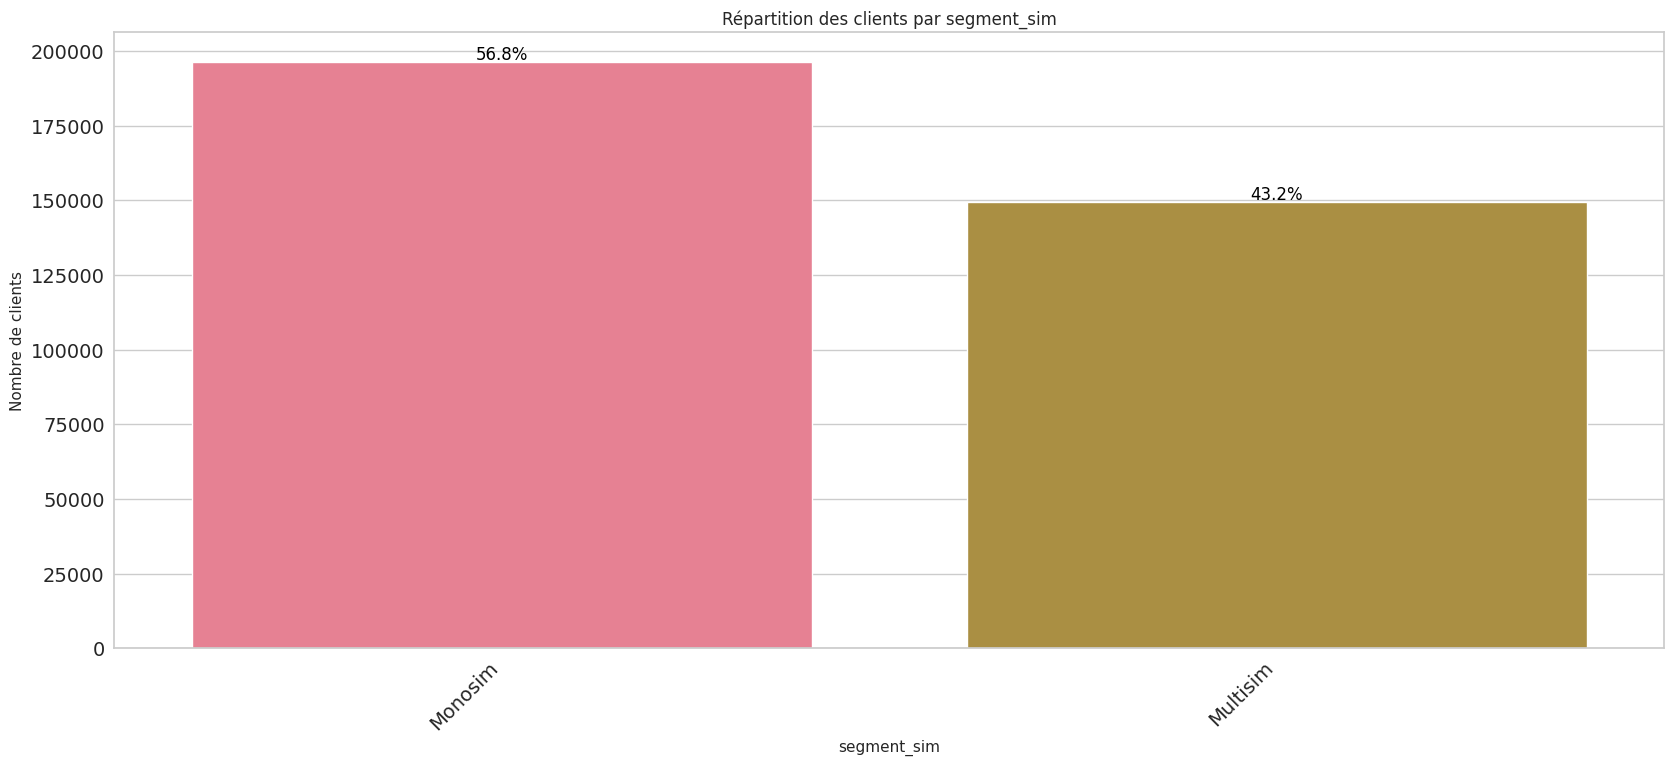

In [ ]:
plot_colonne_distribution(pd_multisim0,"segment_sim")

<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


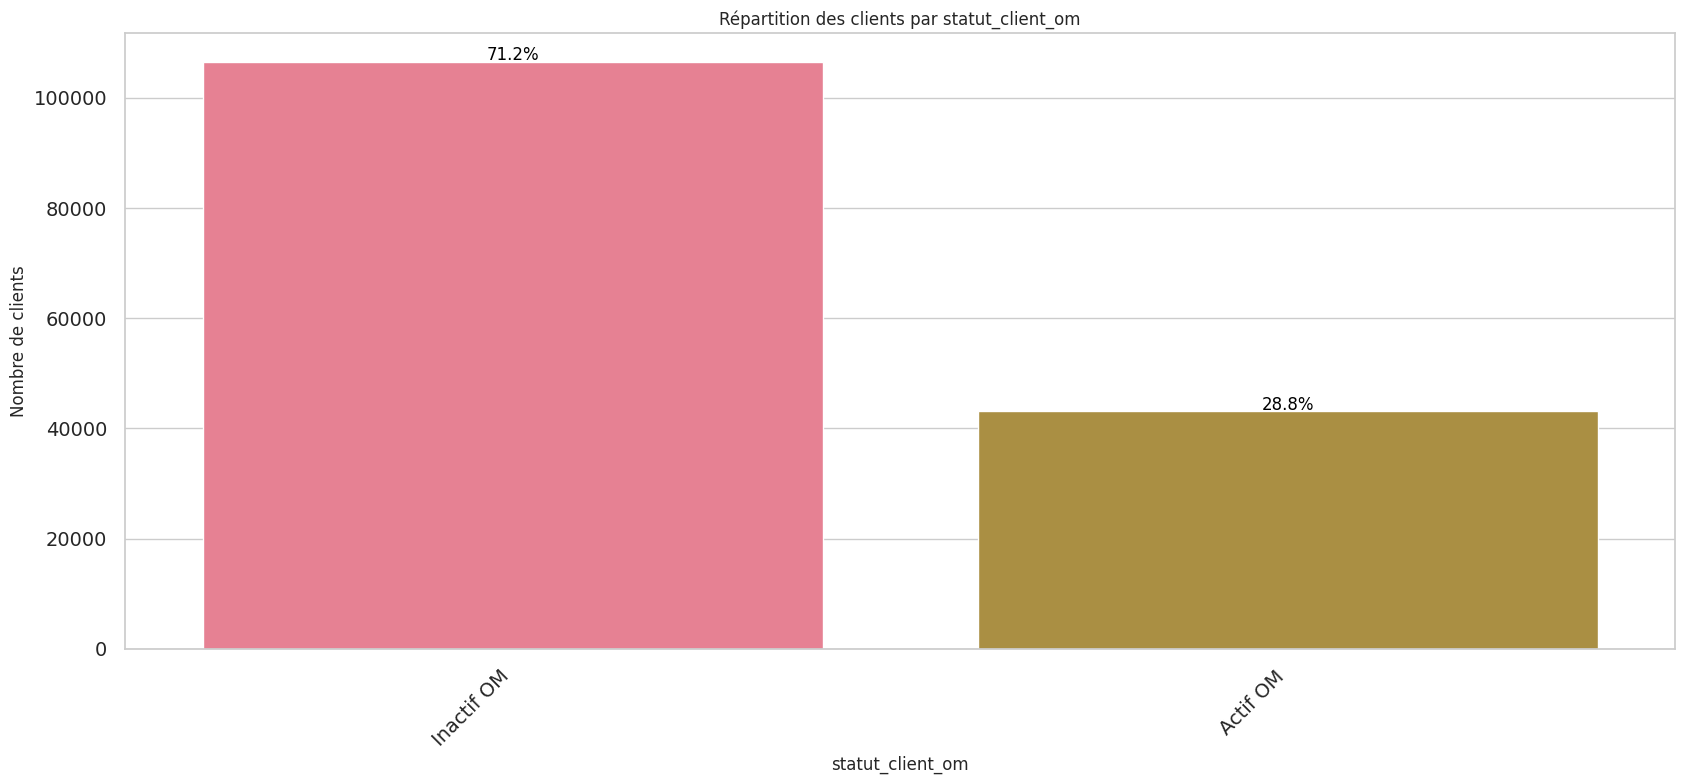

In [ ]:
plot_colonne_distribution(pd_multisim2,"statut_client_om")

#### Segment RFM

LES CLIENTS AVEC OM 




<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: 
The palette list has fewer values (6) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


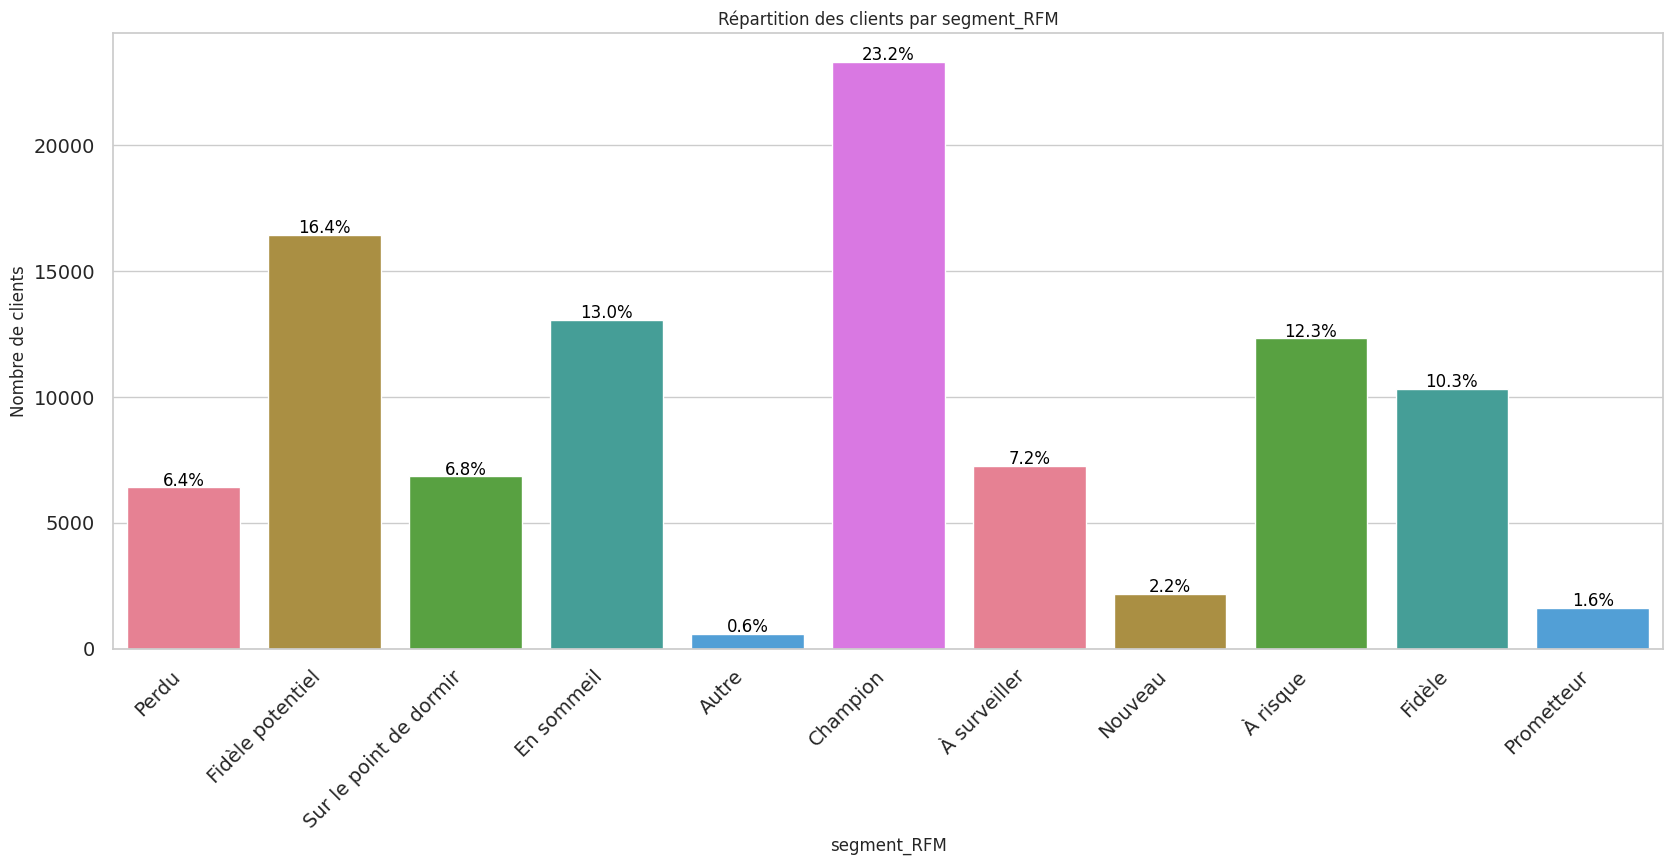

In [ ]:
#SEGMENT RFM
colonne="segment_RFM"
print("LES CLIENTS AVEC OM \n\n")
plot_colonne_distribution(pd_multisim_om0,colonne)



LES CLIENTS MONOSIM AVEC OM 




<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: 
The palette list has fewer values (6) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


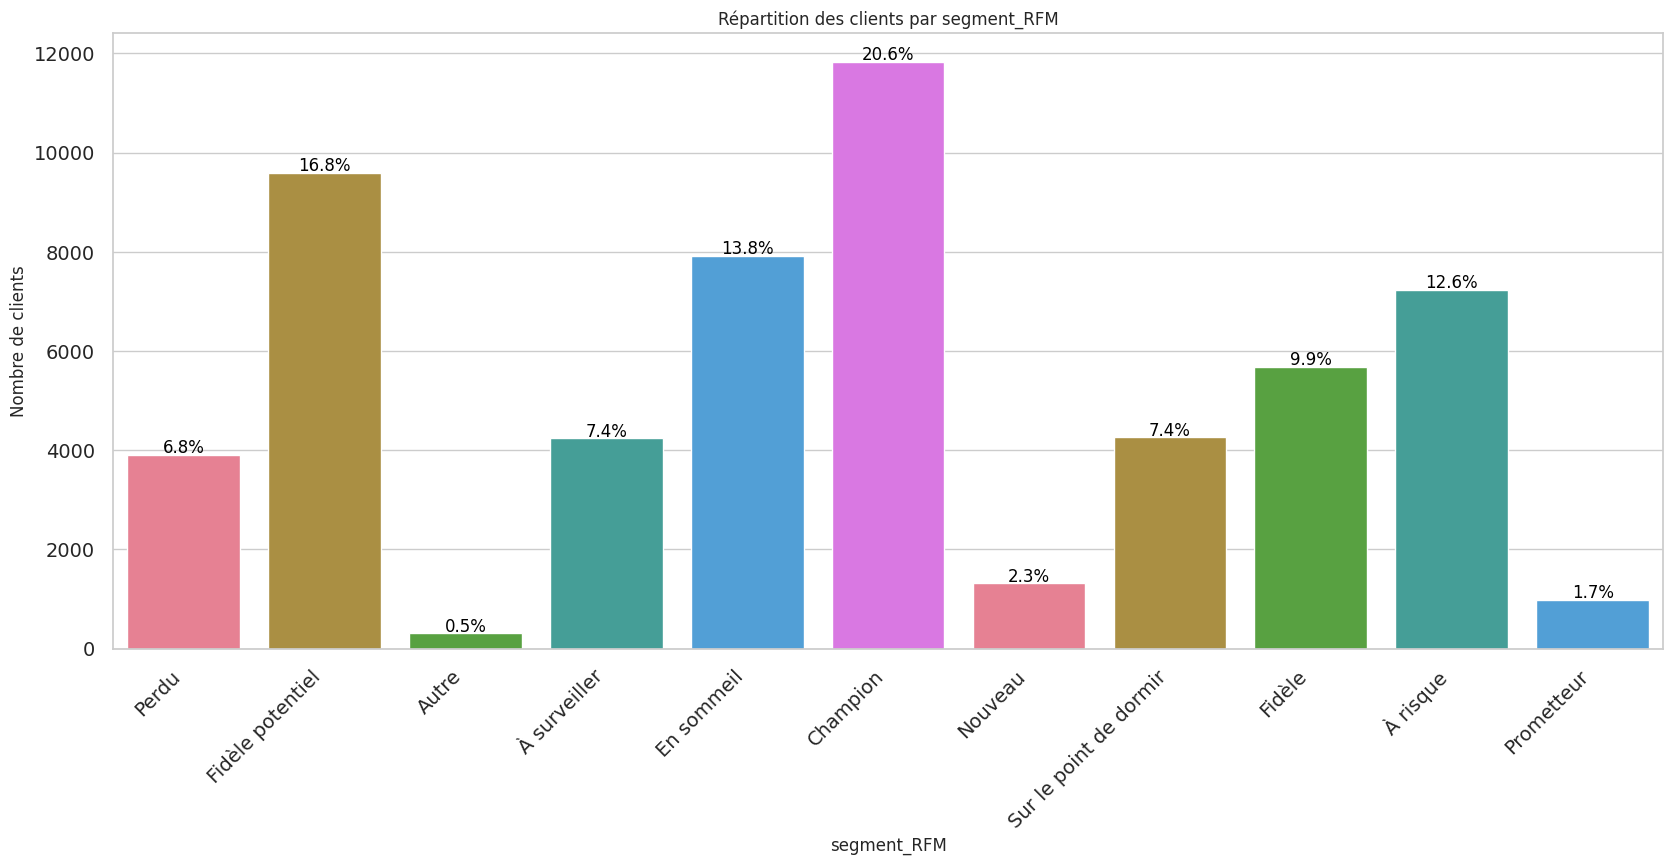

In [ ]:
print("\n\nLES CLIENTS MONOSIM AVEC OM \n\n")
plot_colonne_distribution(pd_multisim_om1,colonne)





LES CLIENTS MULTISIM AVEC OM 




<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: 
The palette list has fewer values (6) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


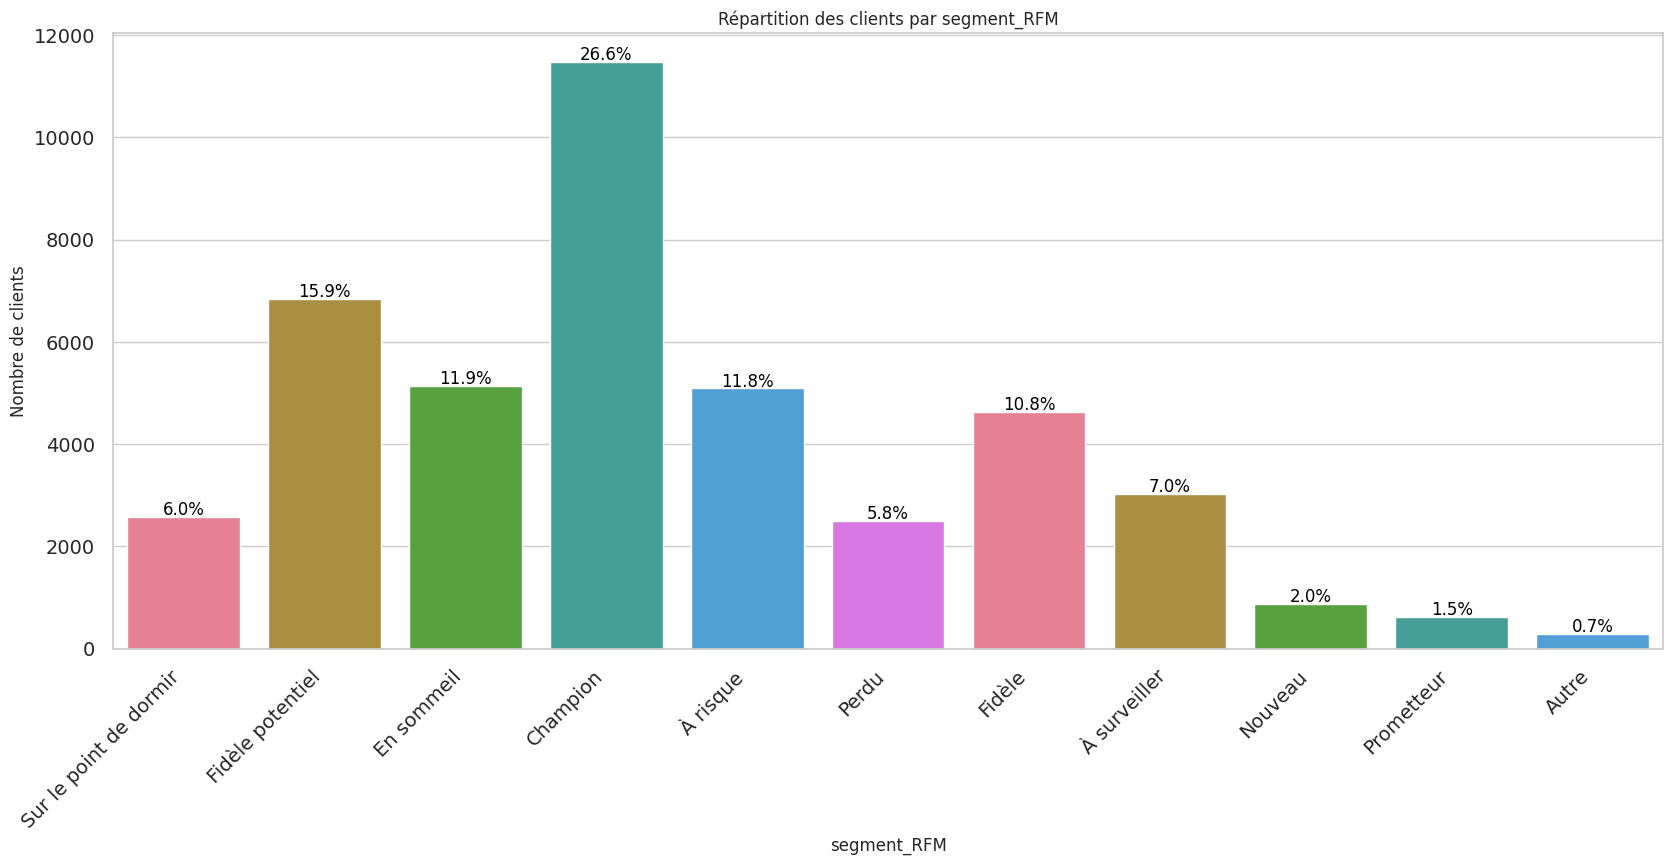

In [ ]:
print("\n\n\n\nLES CLIENTS MULTISIM AVEC OM \n\n")
plot_colonne_distribution(pd_multisim_om2,colonne)

#### Segment recharge

LES CLIENTS SANS DISTINCTION 




<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


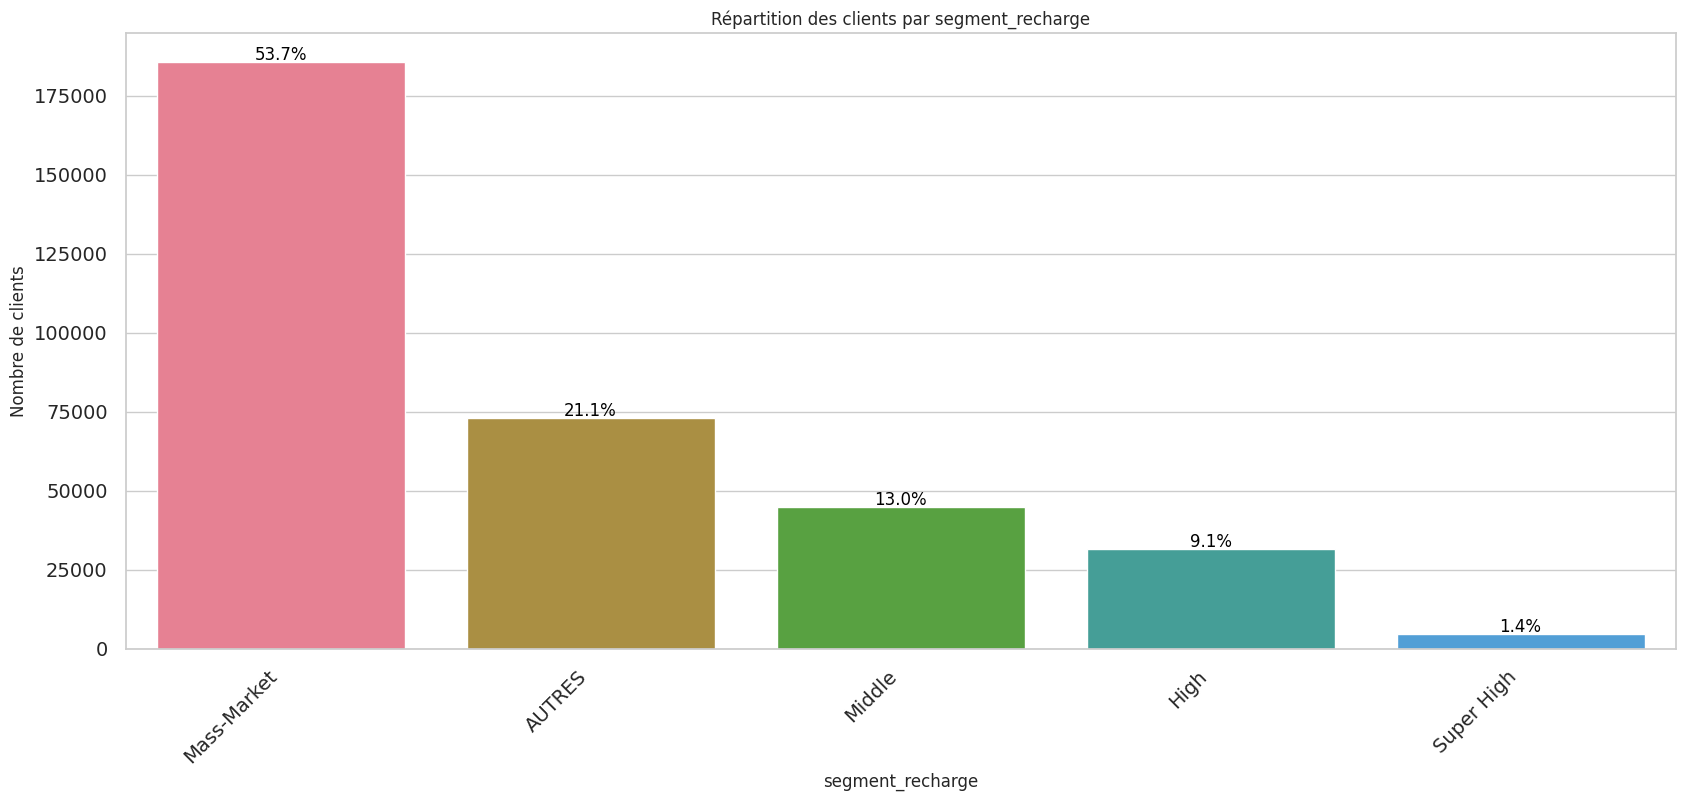

In [ ]:
#SEGMENT RECHARGE
colonne="segment_recharge"
print("LES CLIENTS SANS DISTINCTION \n\n")
plot_colonne_distribution(pd_multisim0,colonne)



LES CLIENTS MONOSIM 




<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


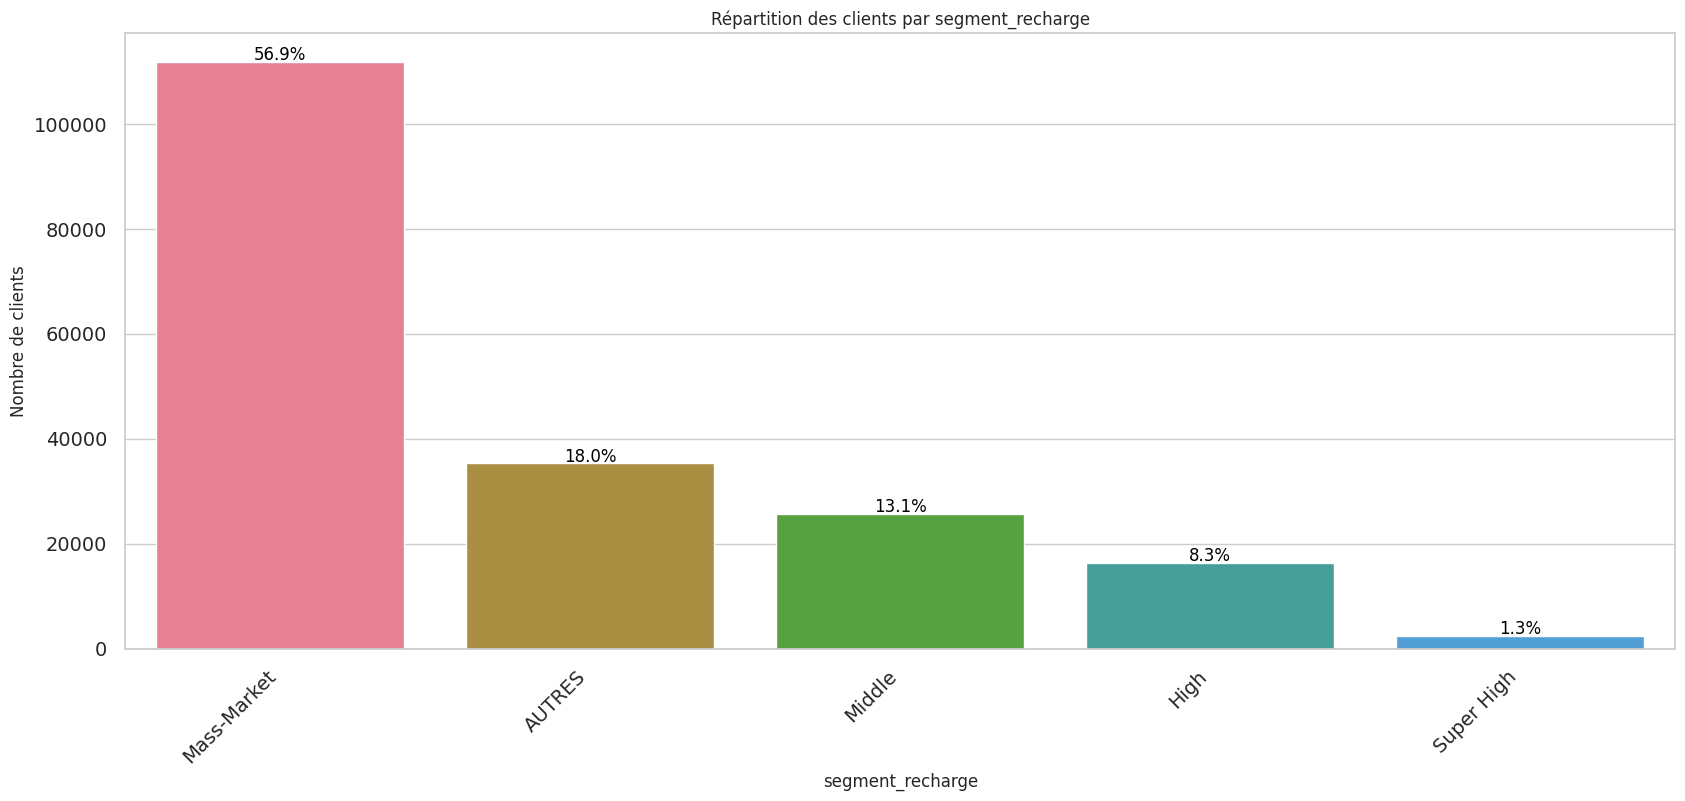

In [ ]:
print("\n\nLES CLIENTS MONOSIM \n\n")
plot_colonne_distribution(pd_multisim1,colonne)





LES CLIENTS MULTISIM 




<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


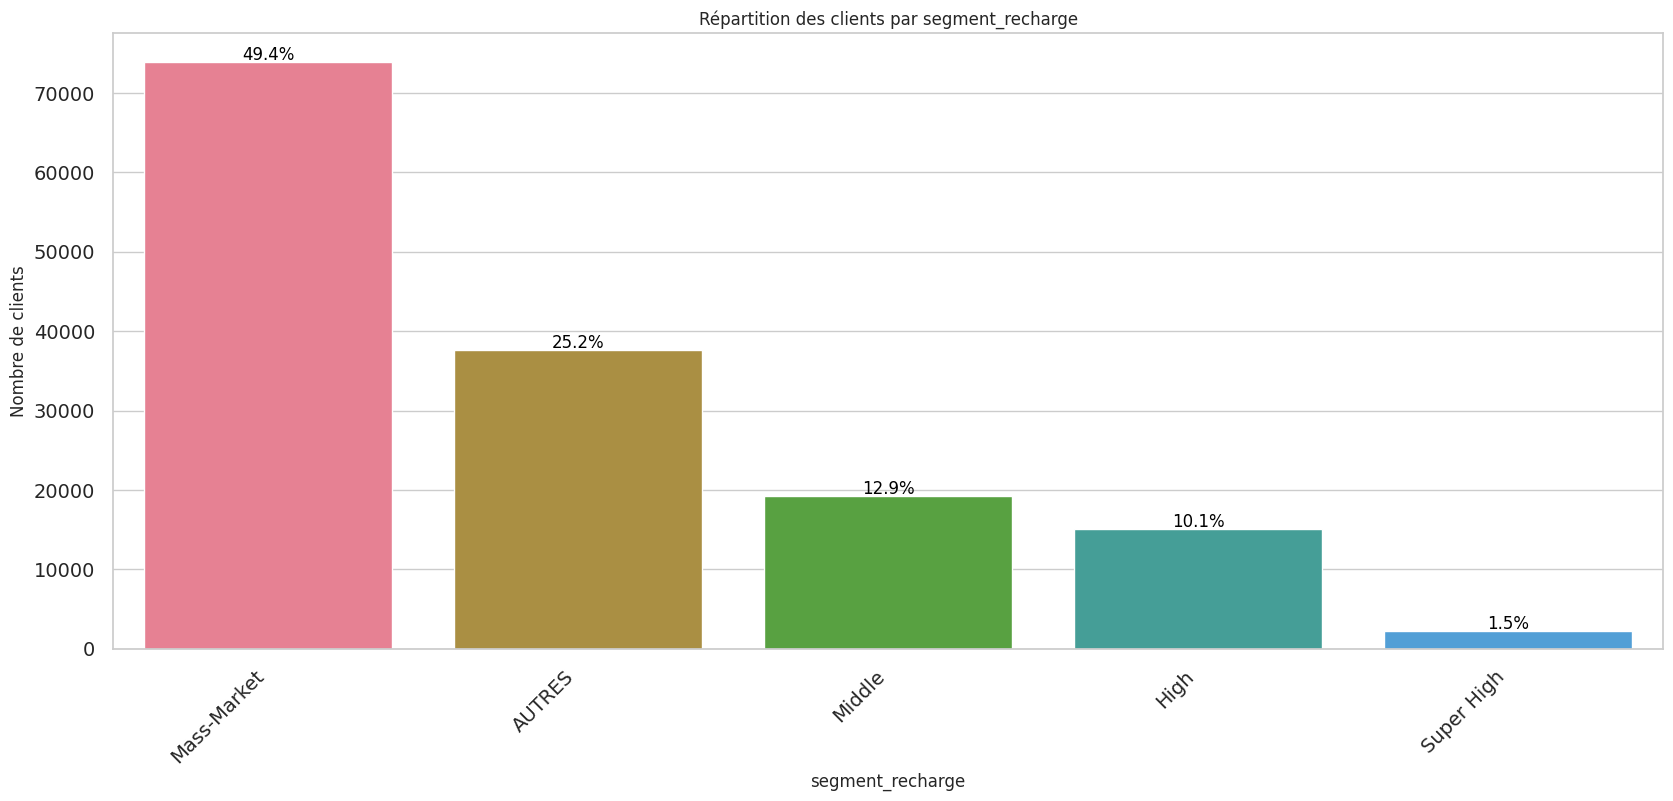

In [ ]:
print("\n\n\n\nLES CLIENTS MULTISIM \n\n")
plot_colonne_distribution(pd_multisim2,colonne)

#### Segment marché

LES CLIENTS SANS DISTINCTION 




<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


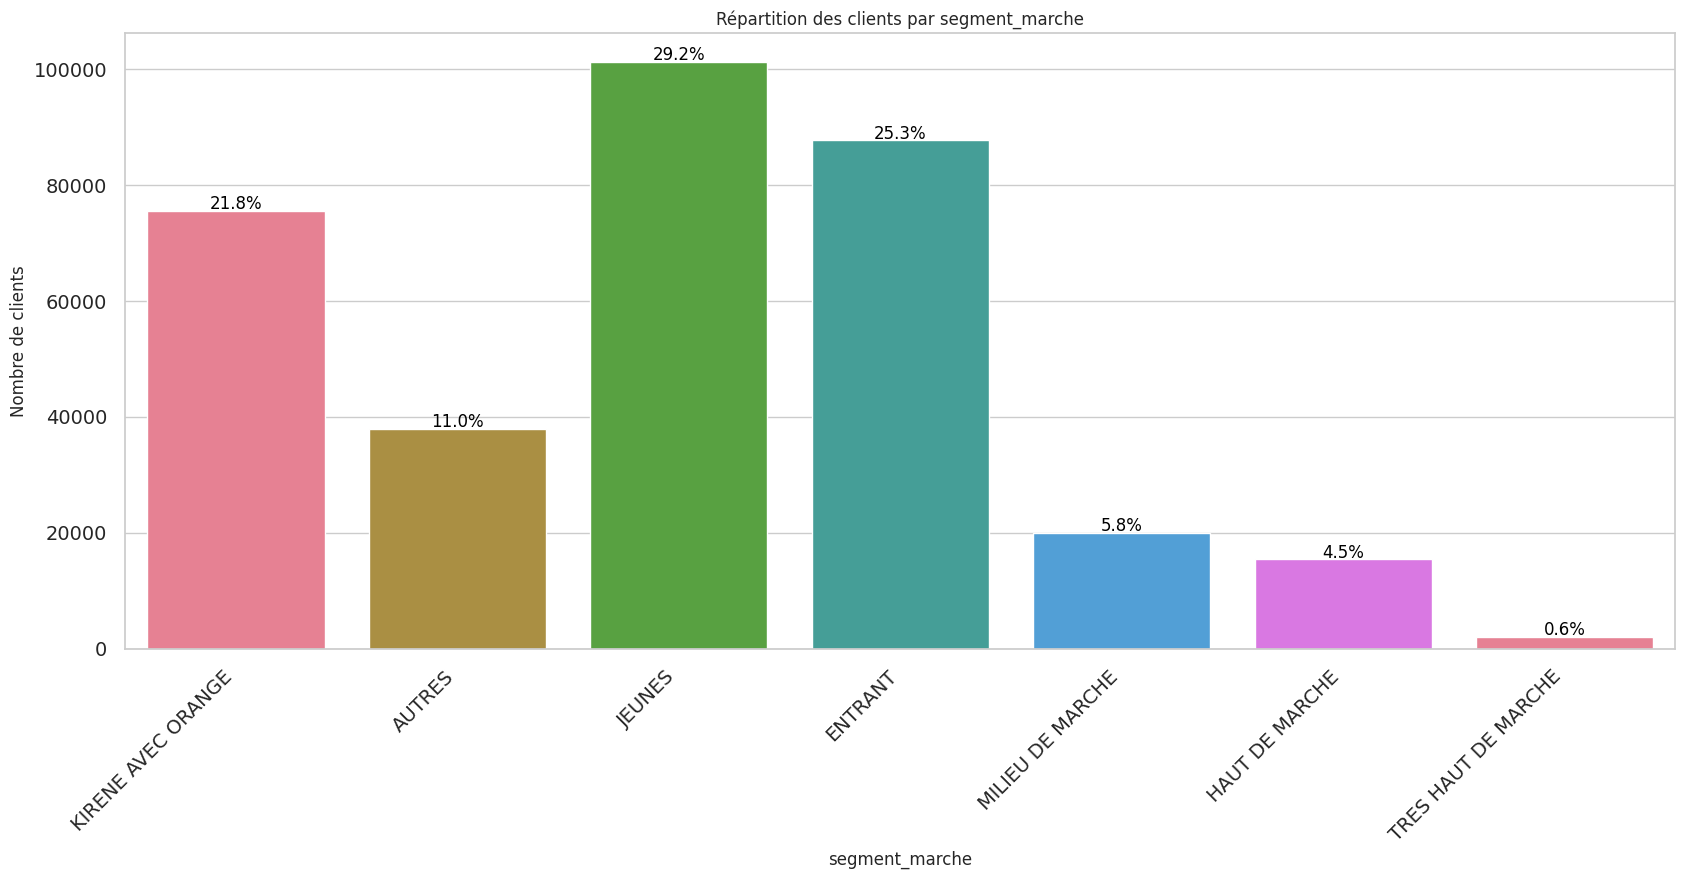

In [ ]:
#SEGMENT MARCHE
colonne="segment_marche"
print("LES CLIENTS SANS DISTINCTION \n\n")
plot_colonne_distribution(pd_multisim0,colonne)



LES CLIENTS MONOSIM 




<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


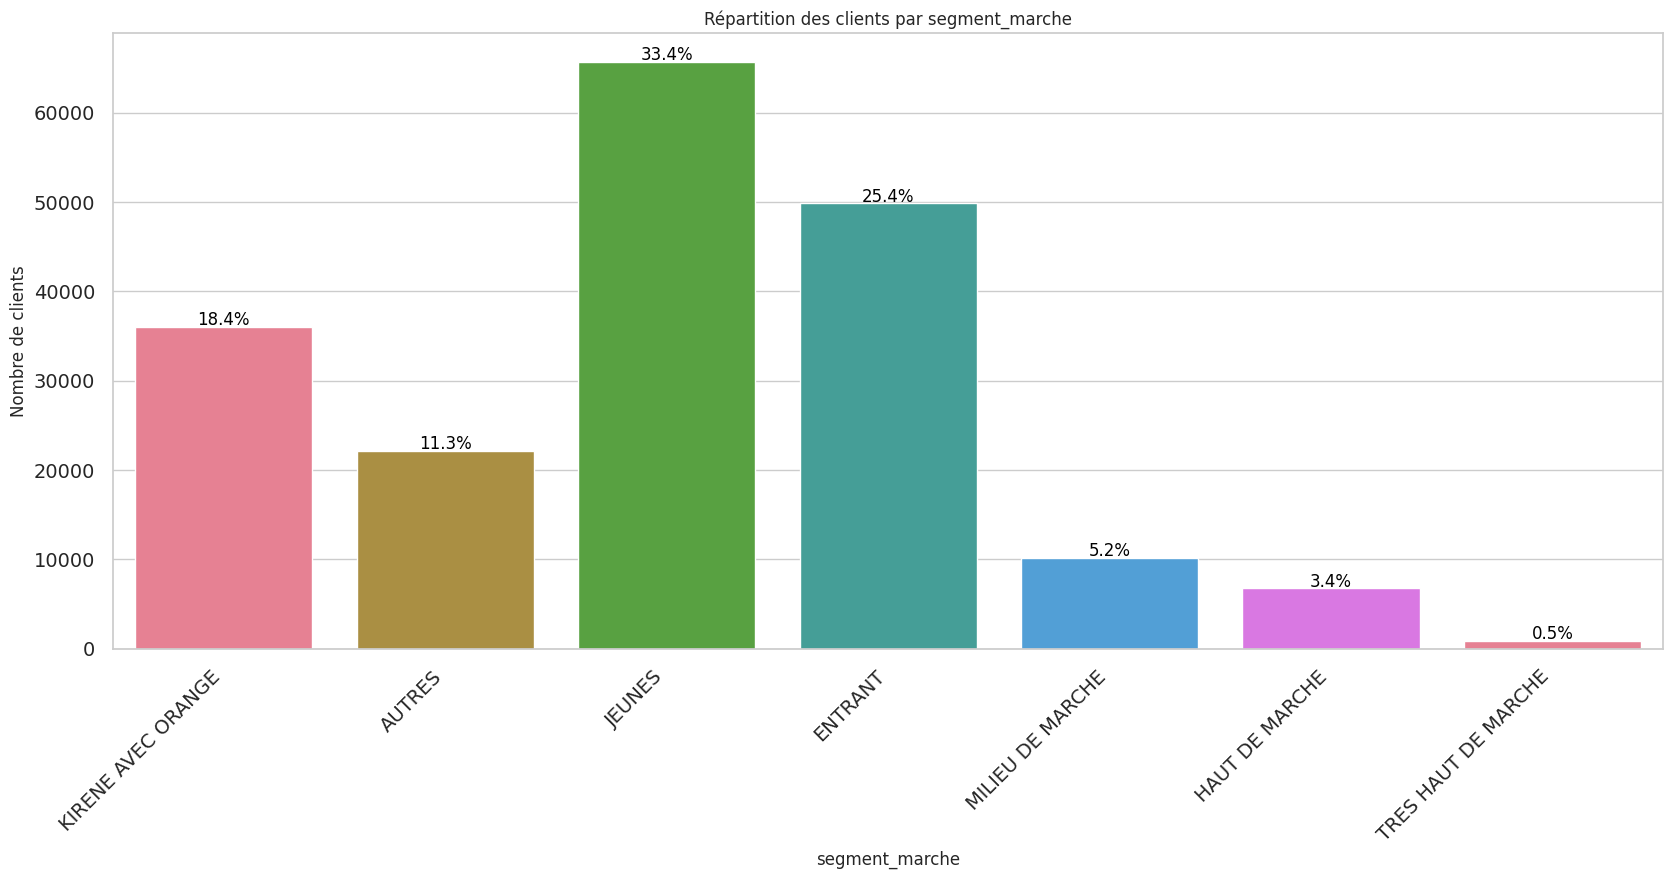

In [ ]:
print("\n\nLES CLIENTS MONOSIM \n\n")
plot_colonne_distribution(pd_multisim1,colonne)





LES CLIENTS MULTISIM 




<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


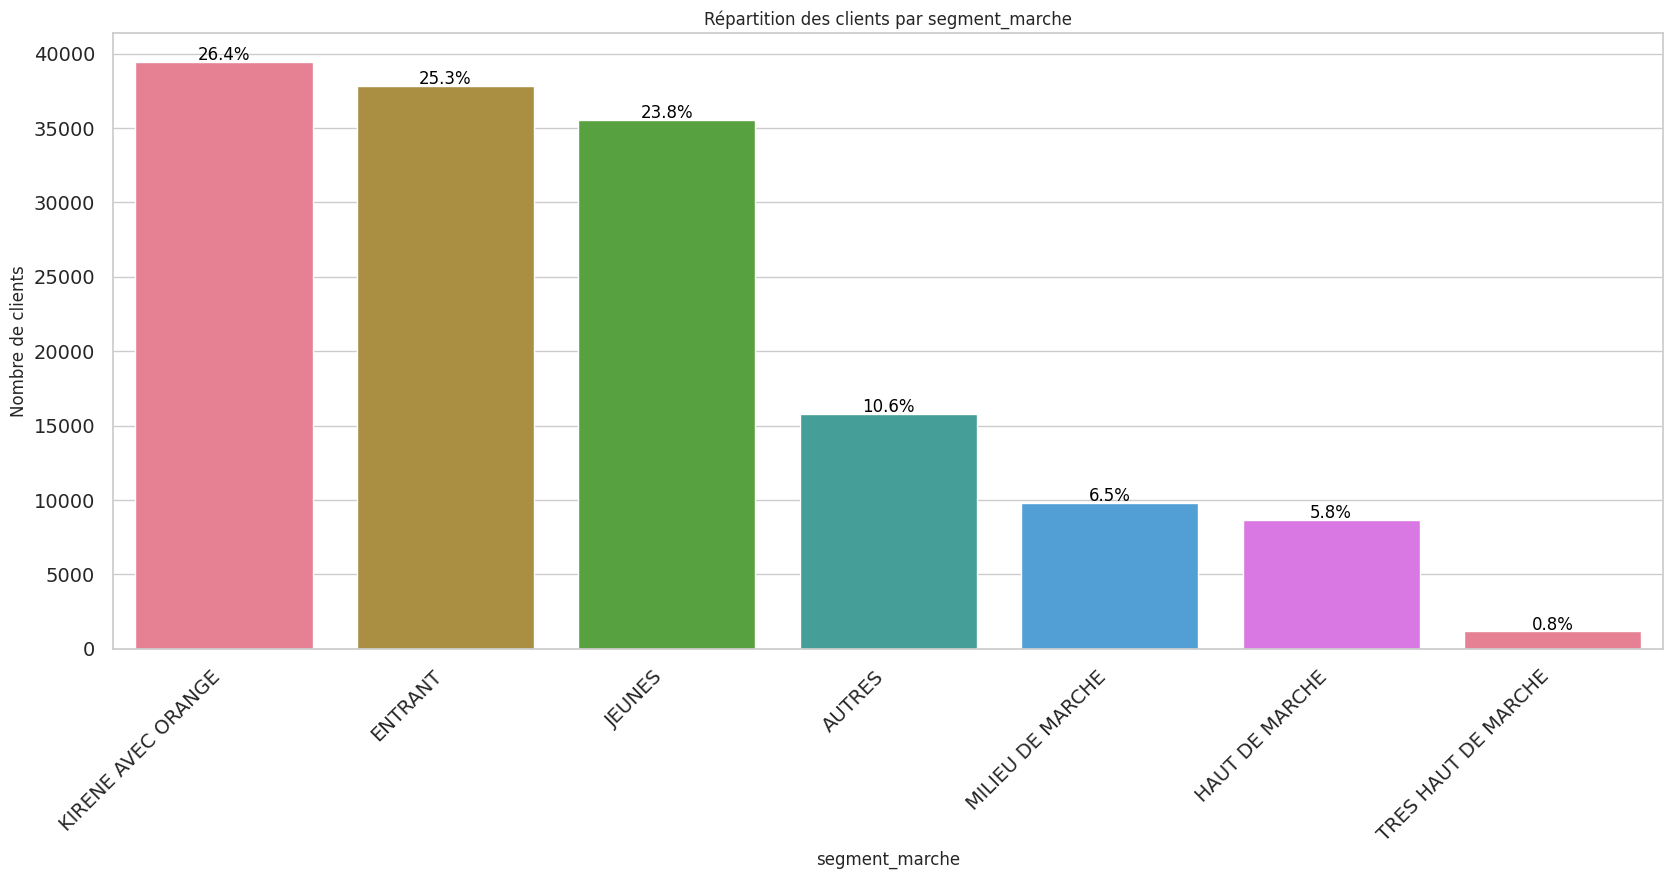

In [ ]:
print("\n\n\n\nLES CLIENTS MULTISIM \n\n")
plot_colonne_distribution(pd_multisim2,colonne)

#### Age

LES CLIENTS SANS DISTINCTION 




<ipython-input-12-0f9019c83e7e>:13: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.countplot(x='age_group', data=data, palette=custom_palette, ax=ax, hue='age_group', legend=False)
<ipython-input-12-0f9019c83e7e>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


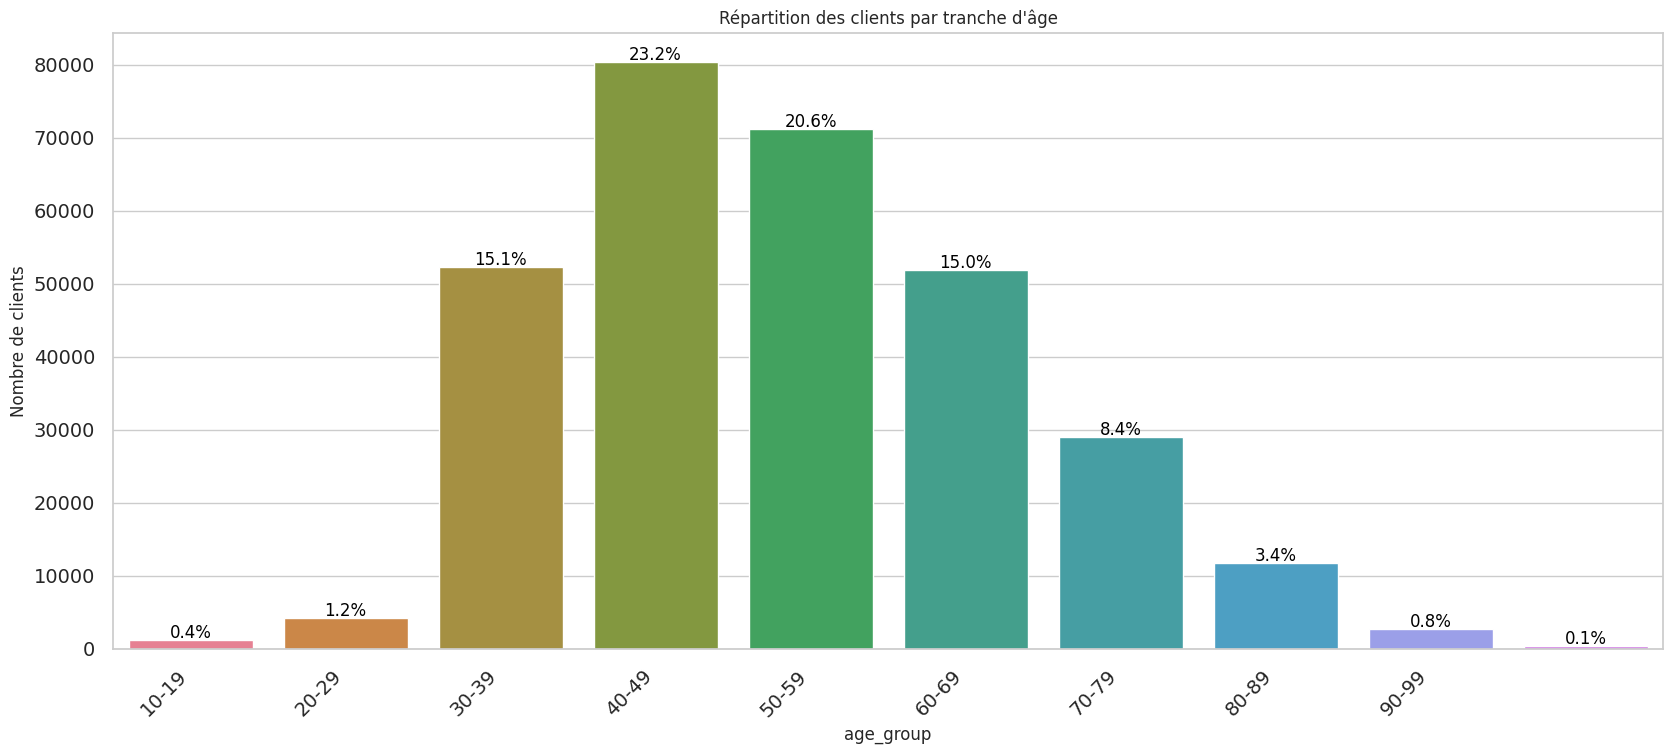

In [ ]:
#AGE
colonne="age"
print("LES CLIENTS SANS DISTINCTION \n\n")
plot_age_distribution(pd_multisim0,colonne,10)



LES CLIENTS MONOSIM 




<ipython-input-12-0f9019c83e7e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_group'] = age_groups
<ipython-input-12-0f9019c83e7e>:13: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.countplot(x='age_group', data=data, palette=custom_palette, ax=ax, hue='age_group', legend=False)
<ipython-input-12-0f9019c83e7e>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


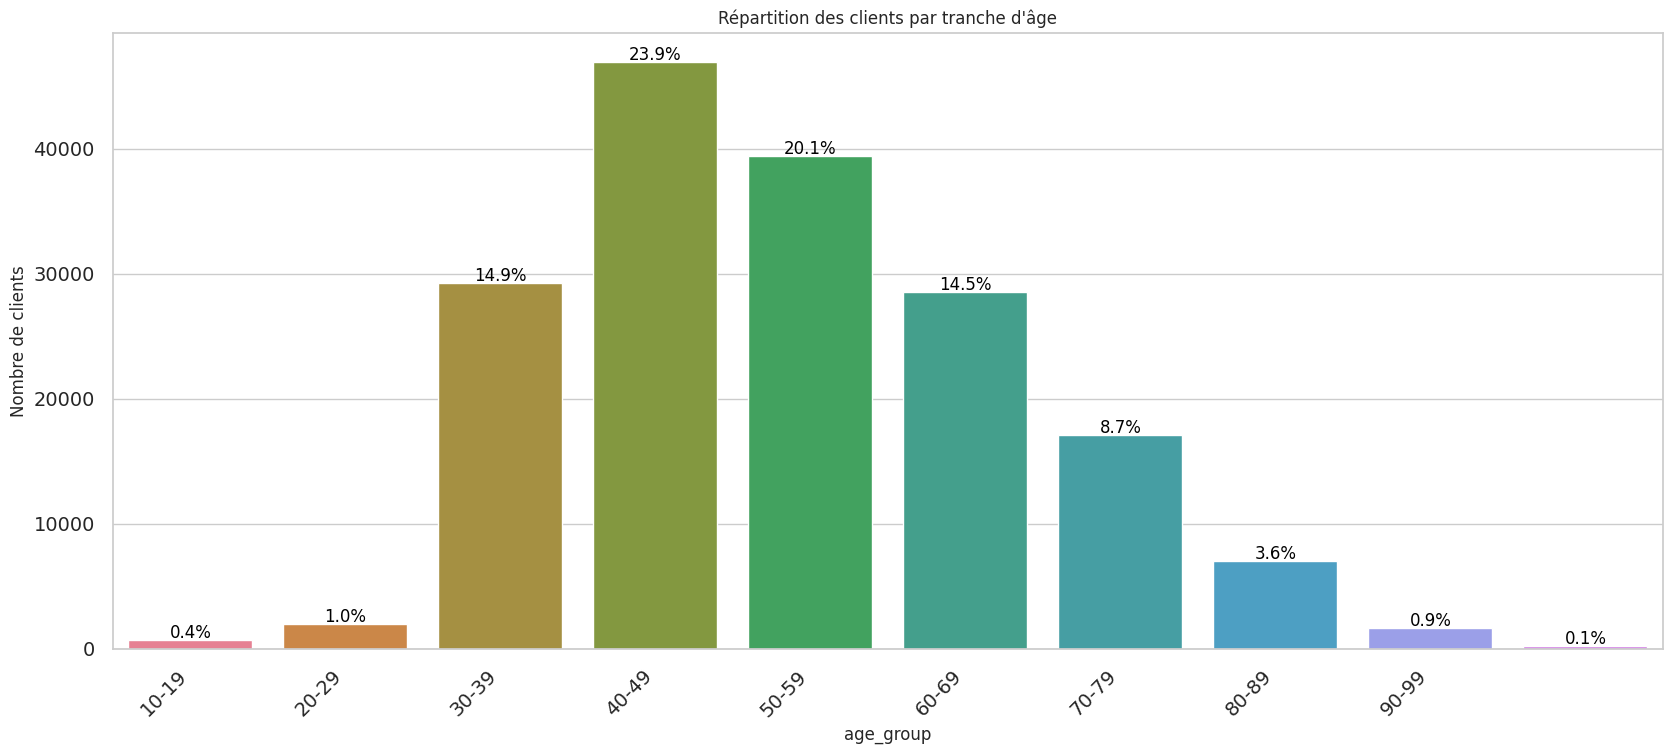

In [ ]:
print("\n\nLES CLIENTS MONOSIM \n\n")
plot_age_distribution(pd_multisim1,colonne)





LES CLIENTS MULTISIM 




<ipython-input-12-0f9019c83e7e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_group'] = age_groups
<ipython-input-12-0f9019c83e7e>:13: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.countplot(x='age_group', data=data, palette=custom_palette, ax=ax, hue='age_group', legend=False)
<ipython-input-12-0f9019c83e7e>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


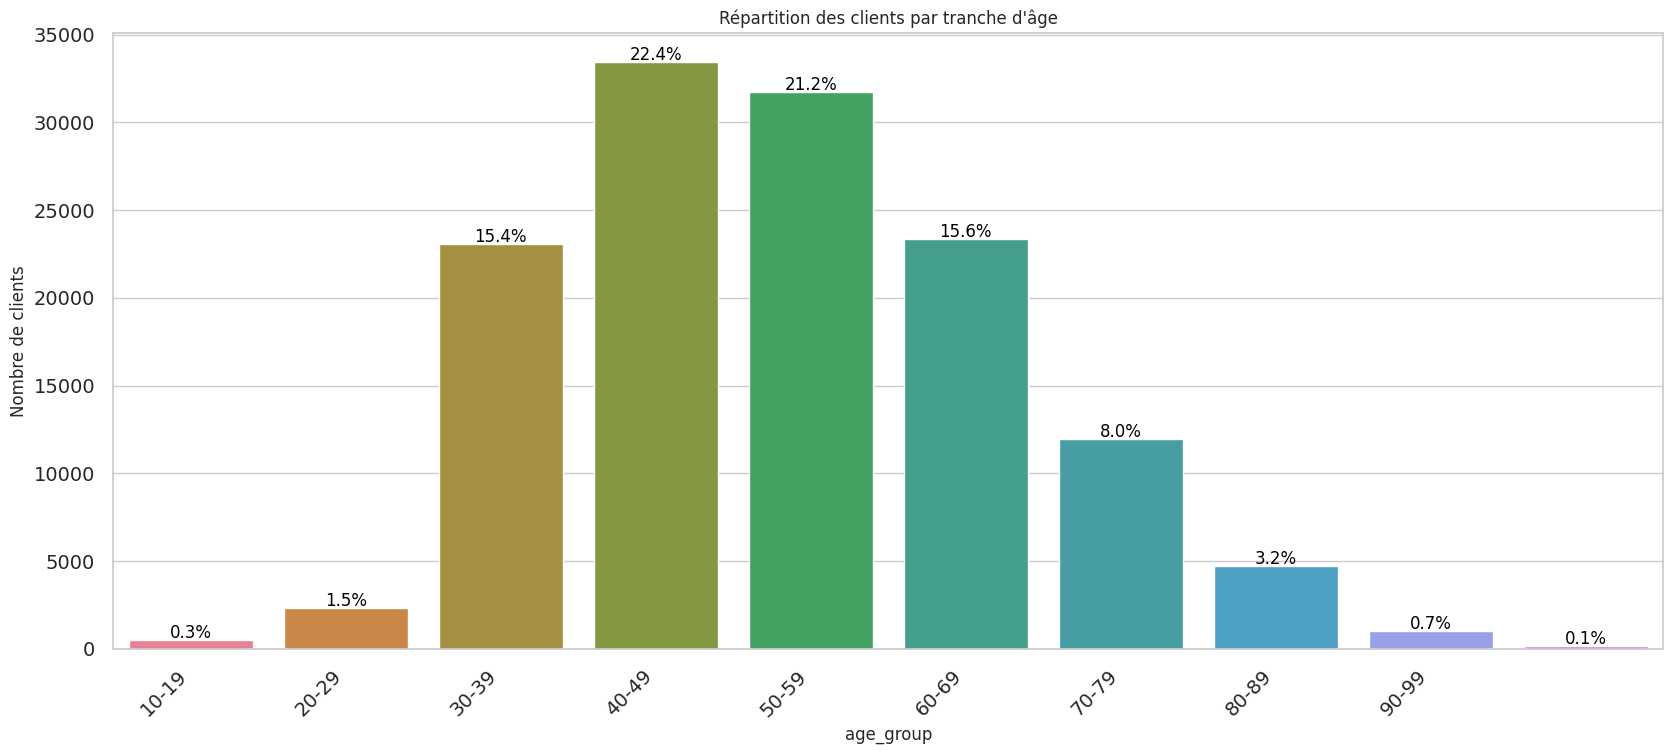

In [ ]:
print("\n\n\n\nLES CLIENTS MULTISIM \n\n")
plot_age_distribution(pd_multisim2,colonne)

#### Anciennete

LES CLIENTS SANS DISTINCTION 




<ipython-input-34-734e40ae700b>:45: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.countplot(x='anciennete_groupes', data=data, palette=custom_palette, ax=ax, hue='anciennete_groupes', legend=False)
<ipython-input-34-734e40ae700b>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


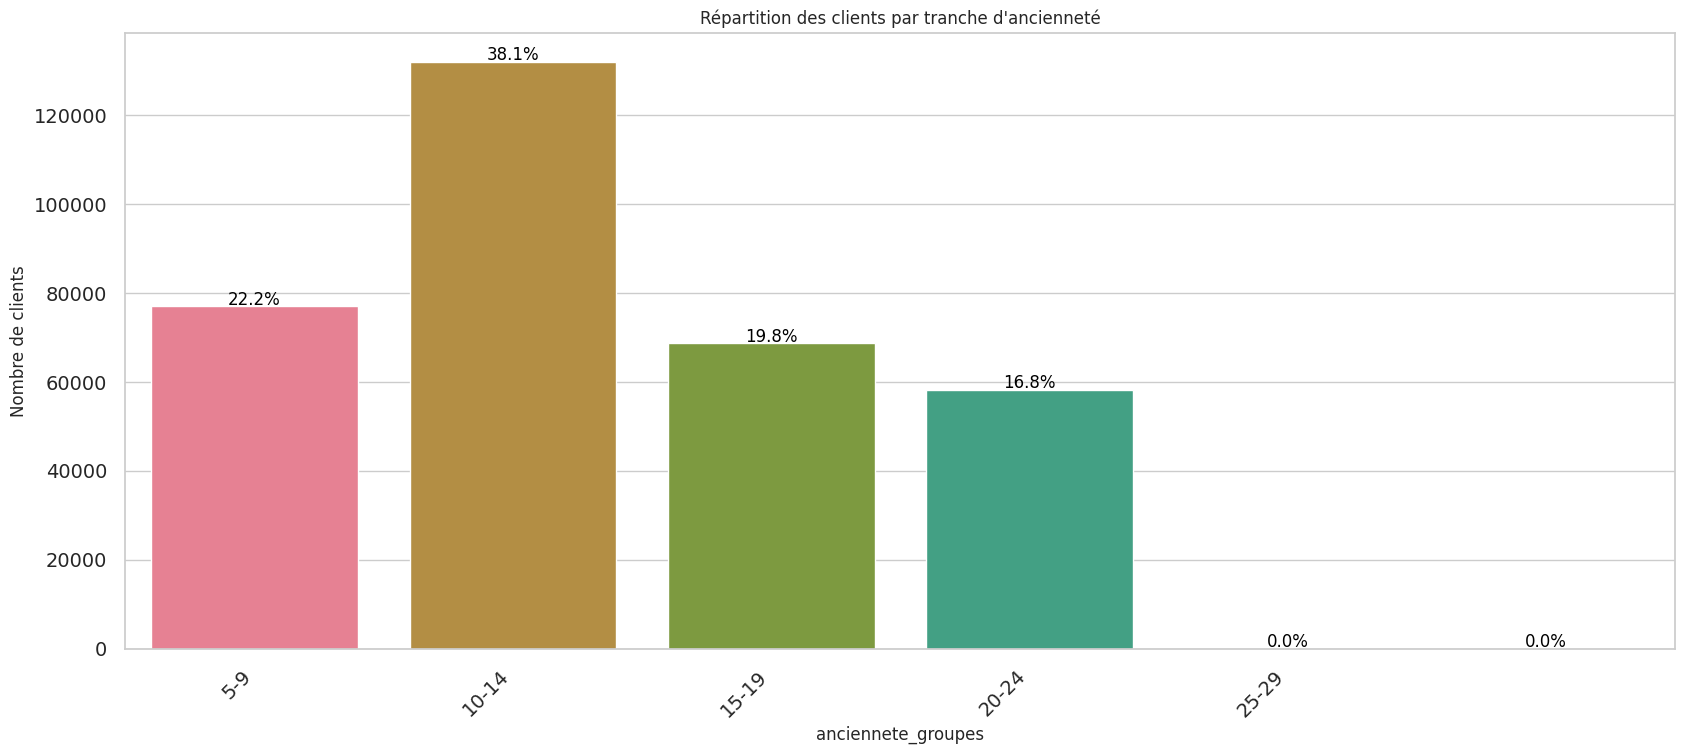

In [ ]:
# AGE
colonne = "anciennete"  # Replace with the actual column name
print("LES CLIENTS SANS DISTINCTION \n\n")
plot_anciennete_distribution(pd_multisim0, colonne, 5)



LES CLIENTS MONOSIM 




<ipython-input-34-734e40ae700b>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['anciennete_groupes'] = age_groups
<ipython-input-34-734e40ae700b>:45: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.countplot(x='anciennete_groupes', data=data, palette=custom_palette, ax=ax, hue='anciennete_groupes', legend=False)
<ipython-input-34-734e40ae700b>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


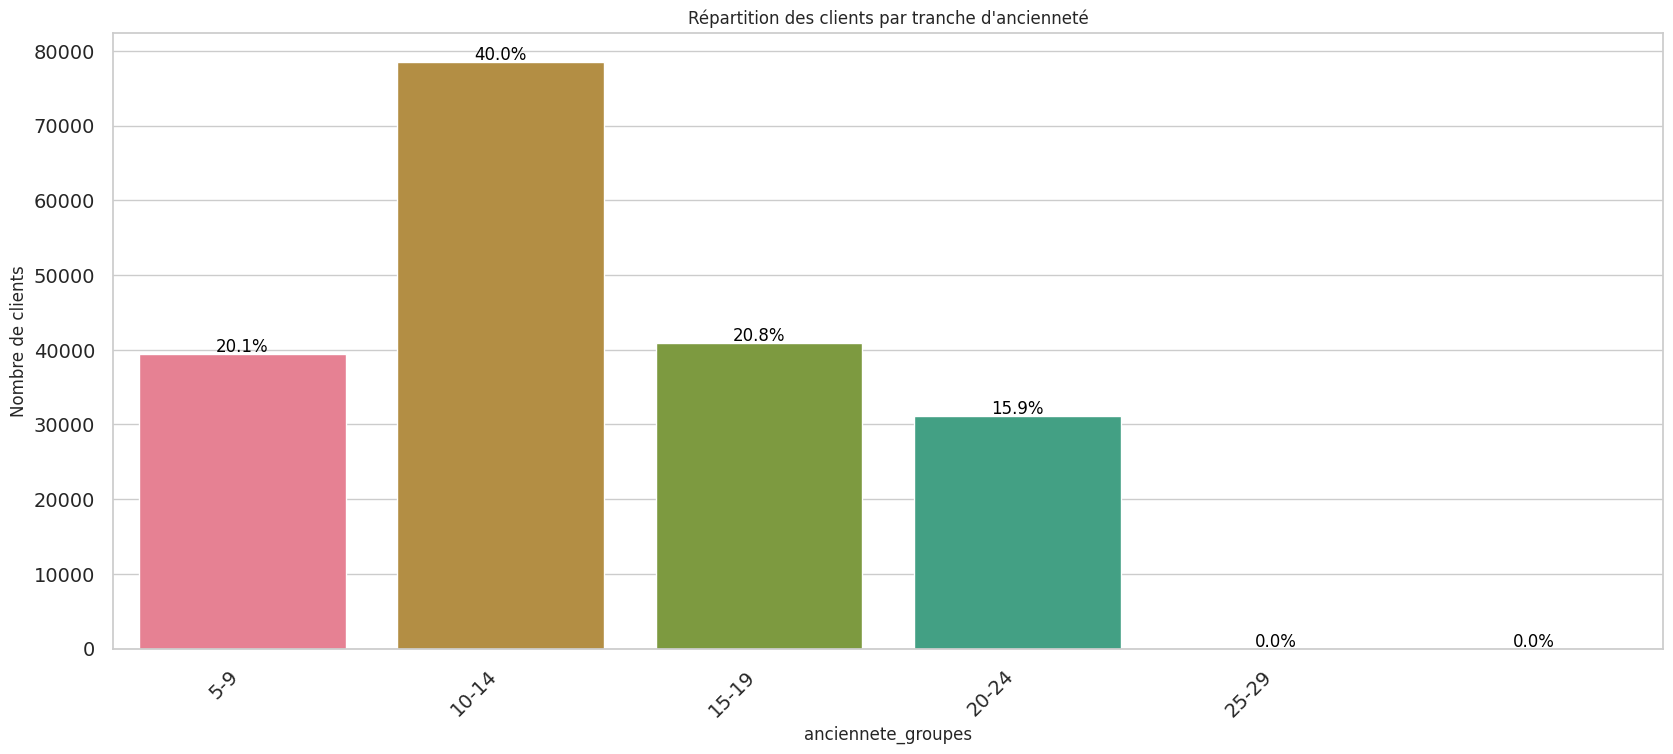

In [ ]:
print("\n\nLES CLIENTS MONOSIM \n\n")
plot_anciennete_distribution(pd_multisim1, colonne, 5)





LES CLIENTS MULTISIM 




<ipython-input-34-734e40ae700b>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['anciennete_groupes'] = age_groups
<ipython-input-34-734e40ae700b>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


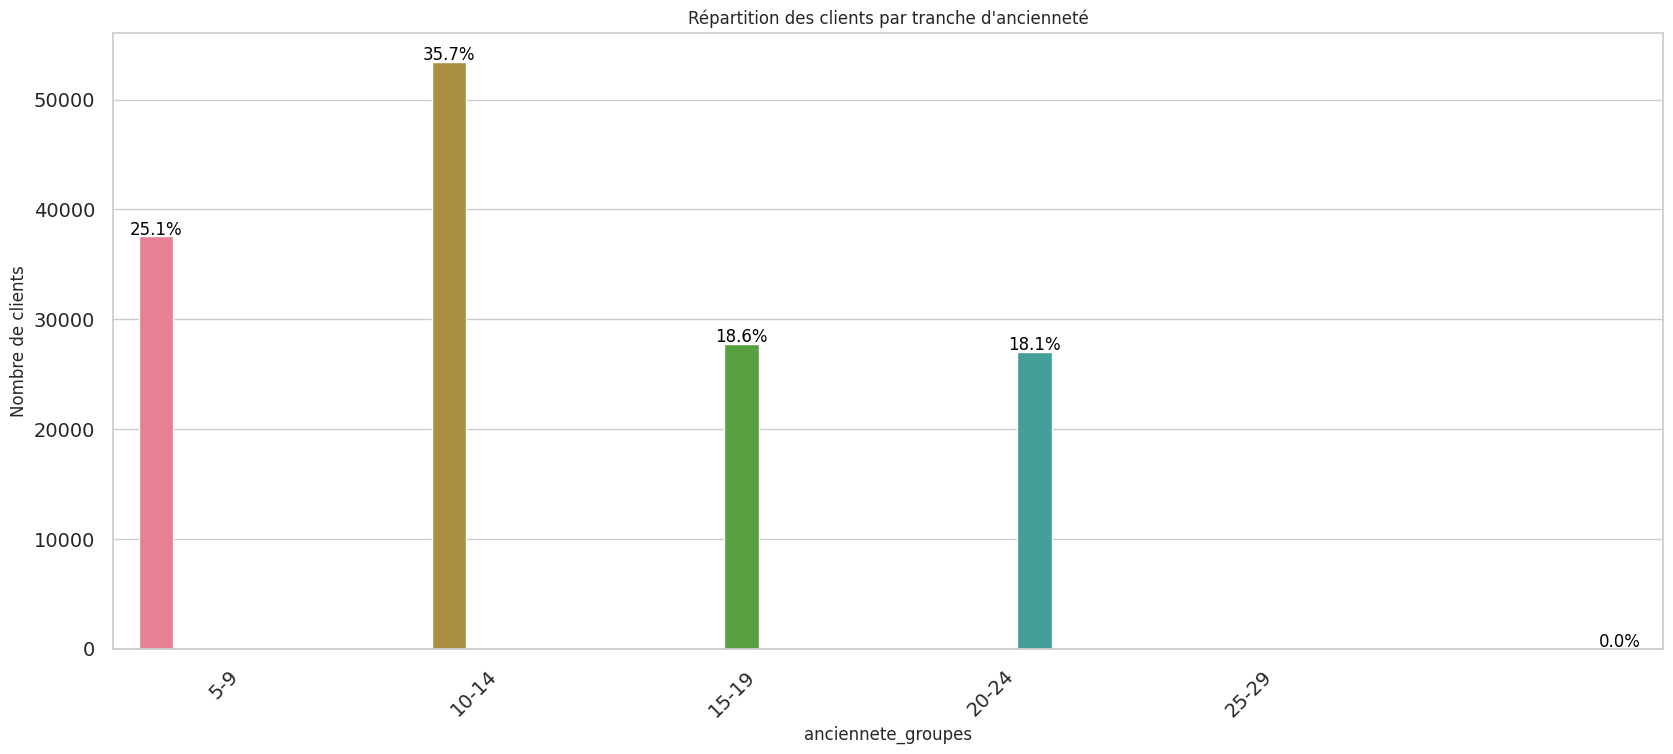

In [ ]:
print("\n\n\n\nLES CLIENTS MULTISIM \n\n")
plot_anciennete_distribution(pd_multisim2, colonne,  5)

#### Communes

<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: 
The palette list has fewer values (6) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


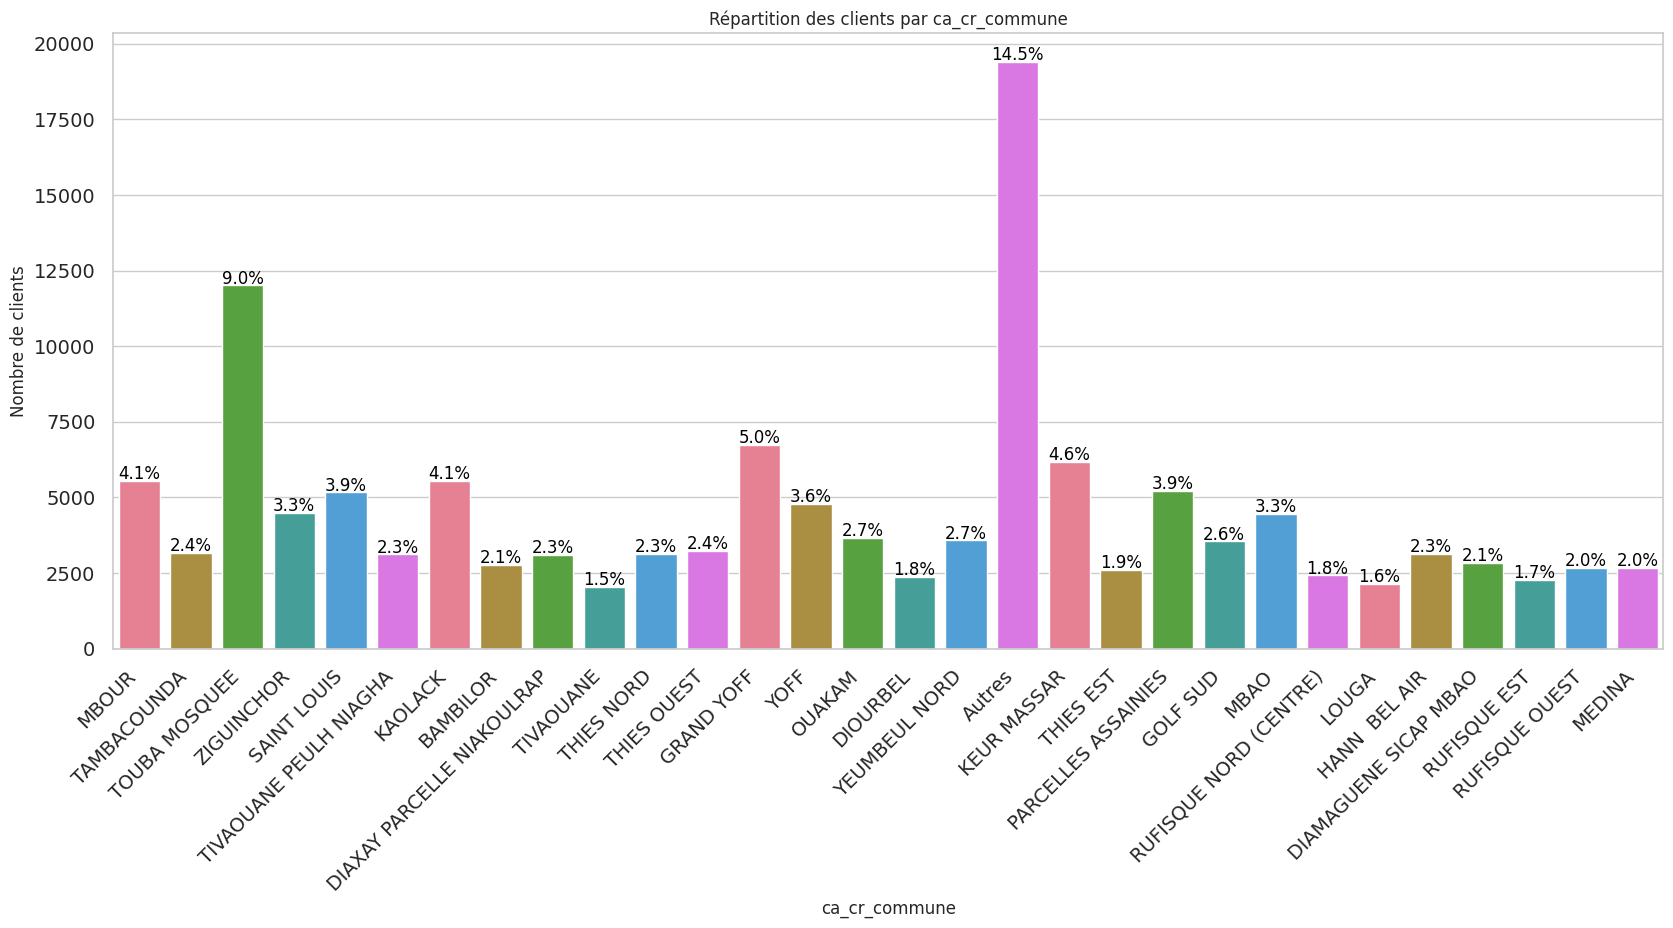

In [ ]:
df=pd_multisim0
top_communes = df['ca_cr_commune'].value_counts().head(30)
df_top_communes = df[df['ca_cr_commune'].isin(top_communes.index)]
plot_colonne_distribution(df_top_communes ,'ca_cr_commune')

<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: 
The palette list has fewer values (6) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


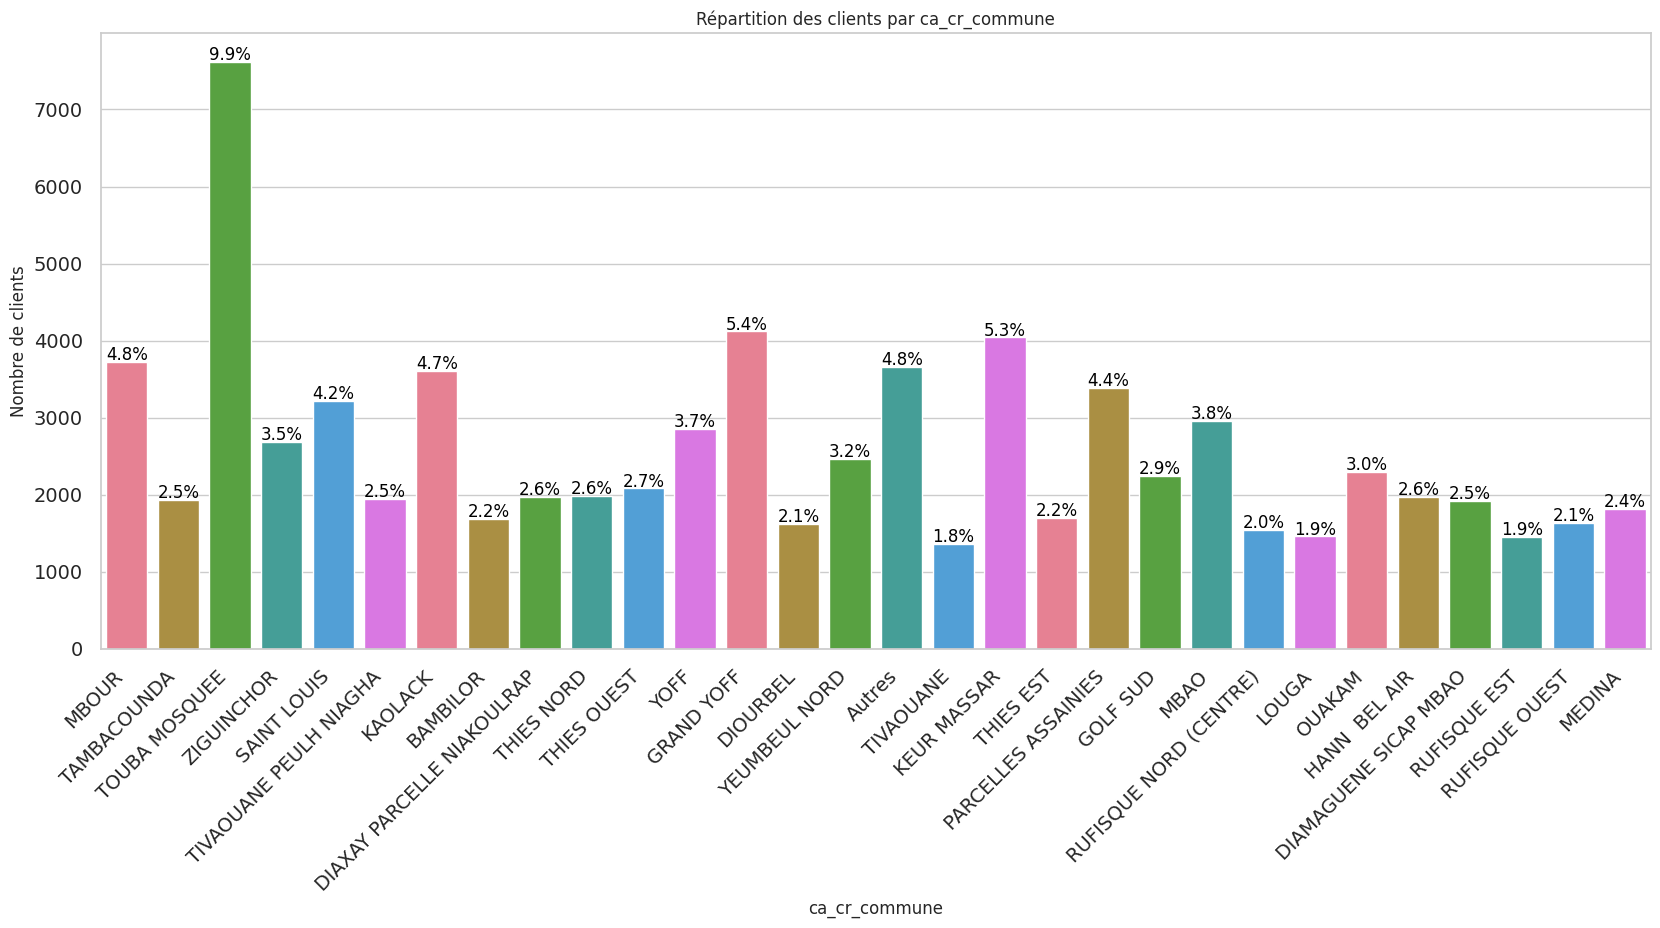

In [ ]:
df=pd_multisim1
top_communes = df['ca_cr_commune'].value_counts().head(30)
df_top_communes = df[df['ca_cr_commune'].isin(top_communes.index)]
plot_colonne_distribution(df_top_communes ,'ca_cr_commune')

<ipython-input-11-cab9baa4bf44>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:15: UserWarning: 
The palette list has fewer values (6) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-cab9baa4bf44>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


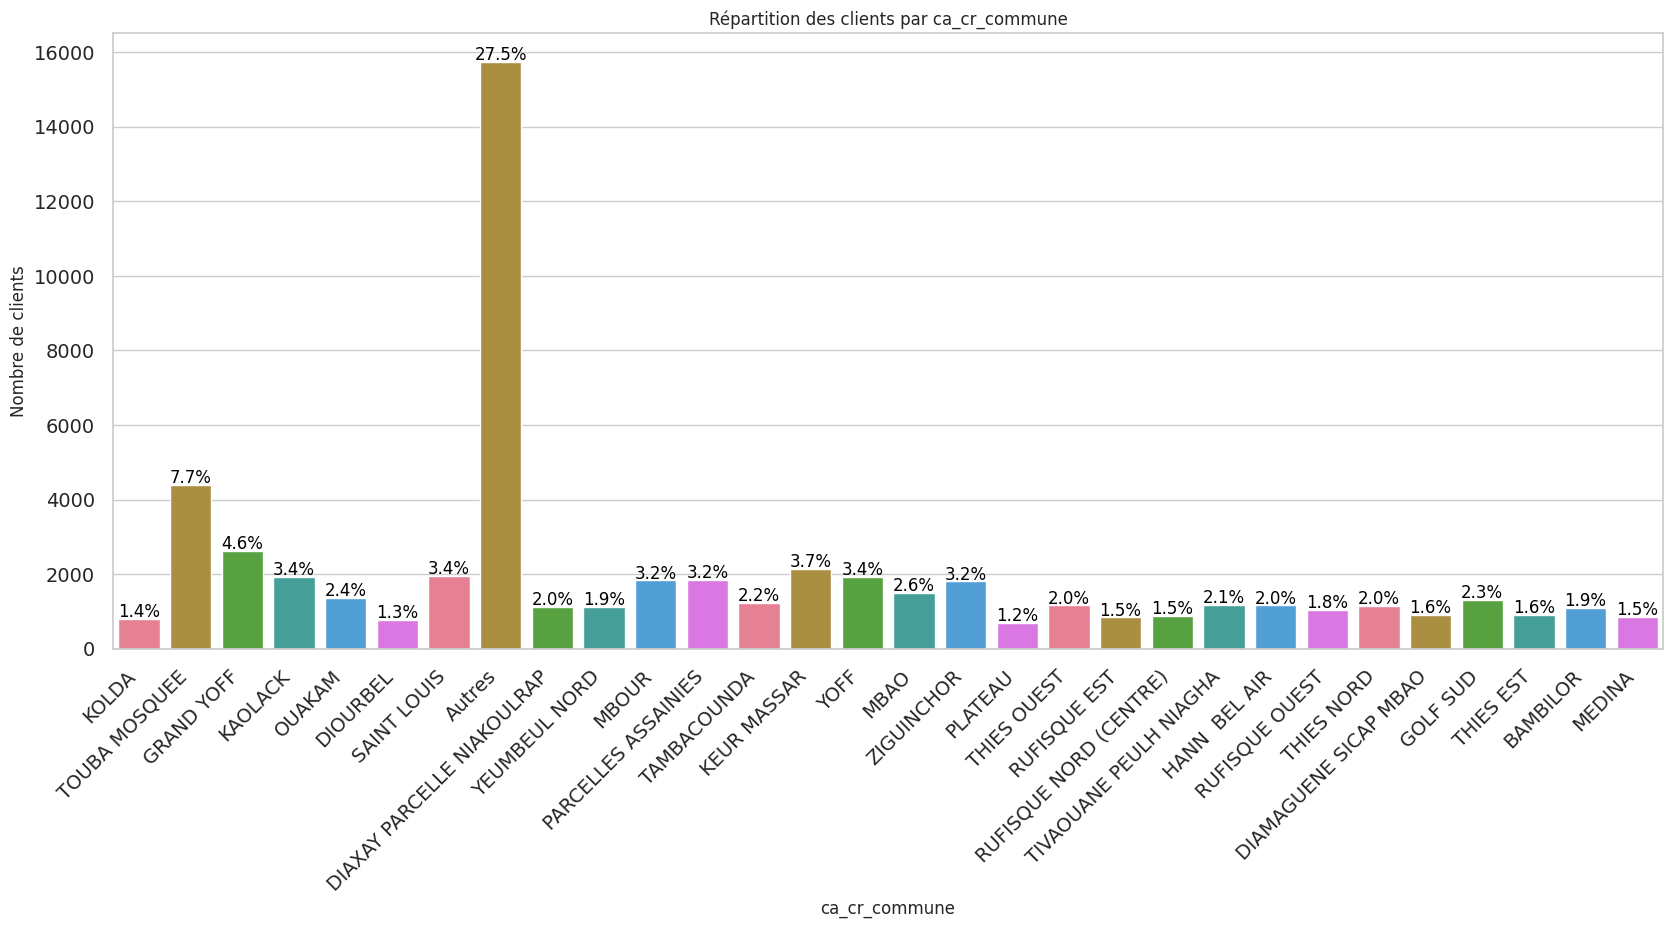

In [ ]:
df=pd_multisim2
top_communes = df['ca_cr_commune'].value_counts().head(30)
df_top_communes = df[df['ca_cr_commune'].isin(top_communes.index)]
plot_colonne_distribution(df_top_communes ,'ca_cr_commune')

# **SEGMENTATION MULTISERVICE ET PALIER**

In [ ]:
def segmenter_palier(df_transaction):

    # Calculate total amount per user
    df_segment_seuil = df_transaction.groupBy("numero").agg(sum("montant").alias("montant_total"))
    ca_client_max = df_segment_seuil.select(max("montant_total")).collect()[0][0]
    # Add 'segment' and 'palier' columns

    df_segment_seuil = df_segment_seuil.withColumn("segment", lit(None)) \
        .withColumn("palier", lit(None)) \
        .withColumn("palier_sup", lit(None)) \
        .withColumn("palier_inf", lit(None))

    # Calculate quantiles
    nombre_quantile = [i / 10 for i in range(10)]
    quantile = df_segment_seuil.approxQuantile("montant_total", nombre_quantile, 0.01)
    quantile[0] = 0
    quantiles = [element * 10 for element in quantile]
    # Define conditions for each segment
    for i in range(1, 10):
        lower_value = quantiles[i - 1]
        upper_value = quantiles[i]
        df_segment_seuil = df_segment_seuil.withColumn(
            "segment",
            when(
                (col("montant_total") > lower_value) & (col("montant_total") <= upper_value),
                f"{i}e palier"
            ).otherwise(df_segment_seuil["segment"])
        )

    # Define conditions for the 10th segment
    df_segment_seuil = df_segment_seuil.withColumn(
        "segment",
        when(
            (col("montant_total") > quantiles[9]) & (col("montant_total") <= ca_client_max),
            "10e palier"
        ).otherwise(df_segment_seuil["segment"])
    )

    # Add 'palier_inf' and 'palier_sup' columns
    df_segment_seuil = df_segment_seuil.withColumn("palier_inf",
                                                   when(col("segment") == "10e palier", lit(quantiles[-1]))) \
        .withColumn("palier_sup", when(col("segment") == "10e palier", lit(ca_client_max)))

    for numero_palier in range(1, 11):
        segment = f"{numero_palier}e palier"
        lower_bound = quantiles[numero_palier - 1] if numero_palier > 1 else quantiles[0]
        upper_bound = ca_client_max if numero_palier == 10 else quantiles[numero_palier]

        df_segment_seuil = df_segment_seuil.withColumn(
            f"palier",
            when(col("segment") == segment, f"[{lower_bound}, {upper_bound}]")
            .otherwise(col(f"palier"))
        ).withColumn(
            f"palier_sup",
            when(col("segment") == segment, f"{upper_bound}")
            .otherwise(col(f"palier_sup"))
        ).withColumn(
            f"palier_inf",
            when(col("segment") == segment, f"{lower_bound}")
            .otherwise(col(f"palier_inf"))
        )
    return df_segment_seuil

In [ ]:
def segmenter_multiservice(df_transaction):
    """
    Effectue la segmentation multiservice des clients.

    Args:
        df (DataFrame): Le DataFrame contenant les données de transaction.

    Returns:
        DataFrame: Le DataFrame avec la segmentation multiservice des clients.
    """


    # Groupement par client (Numéro) et collecte des types de transactions uniques et des canaux uniques
    channel_set = collect_set(df_transaction["channel"]).alias("canaux")
    service_set = collect_set(df_transaction["type_service"]).alias("services")
    categorie_set = collect_set(df_transaction["categorie_service"]).alias("categories_services")
    multiservice_segmentation = df_transaction.groupBy("numero").agg(
        service_set,
        size(service_set).alias("nombre_services"),
        categorie_set,
        size(categorie_set).alias("nombre_categories"),
        channel_set,
        size(channel_set).alias("nombre_canaux"),
        count("*").alias("frequence"),
        sum("montant").alias("montant_total"),

    )

    # Définir la valeur du seuil
    seuil = 1
    # Calcul du segment
    multiservice_segmentation = multiservice_segmentation.withColumn("segment_service", when(
        multiservice_segmentation["nombre_services"] <= seuil, "Monoservice").otherwise("Multiservice"))
    multiservice_segmentation = multiservice_segmentation.withColumn("segment_categorie", when(
        multiservice_segmentation["nombre_categories"] <= seuil, "Monocategorie").otherwise("Multicategorie"))
    return multiservice_segmentation


In [ ]:
df_prepared=df_transaction_transform(df_transaction_clean(df_transaction_om))
df_multiserv=segmenter_multiservice(df_prepared)

In [ ]:
df_multiserv.show()

+------+-------------+---------------+-------------------+-----------------+---------------+-------------+---------+-------------+---------------+-----------------+
|numero|     services|nombre_services|categories_services|nombre_categories|         canaux|nombre_canaux|frequence|montant_total|segment_service|segment_categorie|
+------+-------------+---------------+-------------------+-----------------+---------------+-------------+---------+-------------+---------------+-----------------+
|112373|[Remontée UV]|              1|      [Remontée UV]|                1|[DISTRI_MOBILE]|            1|       15|     391399.0|    Monoservice|    Monocategorie|
|168125|[Remontée UV]|              1|      [Remontée UV]|                1|[DISTRI_MOBILE]|            1|        7|     563945.0|    Monoservice|    Monocategorie|
|181432|[Remontée UV]|              1|      [Remontée UV]|                1|[DISTRI_MOBILE]|            1|       33|    2370998.0|    Monoservice|    Monocategorie|
|252590|[R

# **SEGMENTATION VALEUR KMEANS**

## **Feature engineering for Kmeans**

#### Sélection de variables

In [ ]:
def df_km_create_sico(df_sico):
    taken_columns_sico = ['nd', 'date_naissance', 'date_debut_engagement', 'statut']
    df_km_sic = df_sico.select(taken_columns_sico) \
        .withColumnRenamed("nd", "numero") \
        .drop("statut")
    df_km_sic = df_km_sic.withColumn("anciennete", year(current_date()) - year("date_debut_engagement")) \
        .withColumn("age", year(current_date()) - year("date_naissance")).drop("date_naissance") \
        .drop("date_debut_engagement")
    return df_km_sic


def df_km_create_ville(df_location):
    # Renommez la colonne commune_arrondissement en "ville"
    df_clients_top_villes = df_location.select("msisdn", "commune_arrondissement") \
        .withColumnRenamed("commune_arrondissement", "ville") \
        .withColumnRenamed("msisdn", "numero")

    # Remplacez les valeurs spécifiques
    replacements = {
        "NDAME": "TOUBA",
        "NIAYES": "KEUR MASSAR",
        "PIKINE DAGOUDANE": "PIKINE",
        "BAMBILOR": "SANGALKAM"
    }

    # Use when for replacements
    for old_value, new_value in replacements.items():
        df_clients_top_villes = df_clients_top_villes.withColumn("ville",
                                                                 when(col("ville") == old_value, new_value).otherwise(
                                                                     col("ville")))

    # Group by "numero" and select the most frequent "ville"
    df_clients_top_villes = df_clients_top_villes.groupBy("numero", "ville") \
        .agg(count("*").alias("count")) \
        .orderBy(desc("count")) \
        .groupBy("numero") \
        .agg(first("ville").alias("ville"))

    return df_clients_top_villes


def df_km_create_transaction_aggregated(df_transaction, latest_date = "2023-12-31"):

    # Aggregate step 1
    df_km_transaction_aggregated0 = df_transaction.groupBy("numero") \
        .agg(datediff(lit(latest_date), max(df_transaction["day"])).alias("recence"),
             count("*").alias("frequence_total"),
             sum(df_transaction["montant"].cast("double")).alias("montant_total"))

    # Aggregate step 2
    resultat_destinataires = df_transaction.filter(col("type_service") == "Transfert") \
        .groupBy("numero").agg(countDistinct("destinataire").alias("nombre_destinataires"))

    # Calcul du nombre de réceptions pour chaque msisdn en tant que destinataire
    resultat_receptions=  df_transaction.filter(col("type_service") == "Transfert") \
            .groupBy("destinataire").agg(count("numero").alias("nombre_receptions"), countDistinct("numero").alias("nombre_expediteurs")) \
            .withColumnRenamed("destinataire","numero")

    # Join the results
    df_km_transaction_aggregated1 = df_km_transaction_aggregated0.join(resultat_destinataires, "numero", "inner")
    df_km_transaction_aggregated=df_km_transaction_aggregated1.join(resultat_receptions,"numero","inner")
    return df_km_transaction_aggregated


def df_km_create_transaction_categorie_service(df_transaction):
    # Créez un DataFrame vide pour stocker les résultats agrégés
    df_km_transaction_categorie = df_transaction

    # Liste des catégories de service uniques
    categories_services = ['service_financier', 'service_paiement', 'service_achat', 'don_cotisation']

    # Utilisez une boucle pour créer des colonnes de montant et de fréquence pour chaque catégorie de service
    for categorie in categories_services:
        # Créez une colonne temporaire pour le montant de la catégorie de service
        col_montant = f"montant_{categorie}"
        df_km_transaction_categorie = df_km_transaction_categorie.withColumn(col_montant, when(
            df_km_transaction_categorie["categorie_service"] == categorie,
            df_km_transaction_categorie["montant"]).otherwise(0))

        # Créez une colonne temporaire pour la fréquence de la catégorie de service
        col_frequence = f"frequence_{categorie}"
        df_km_transaction_categorie = df_km_transaction_categorie.withColumn(col_frequence, when(
            df_km_transaction_categorie["categorie_service"] == categorie, 1).otherwise(0))

    # Effectuez l'agrégation en regroupant par d'autres colonnes si nécessaire
    df_km_transaction_categorie = df_km_transaction_categorie.groupBy("numero").sum()

    # Renommez les colonnes agrégées
    for categorie in categories_services:
        col_montant = f"montant_{categorie}"
        col_frequence = f"frequence_{categorie}"
        df_km_transaction_categorie = df_km_transaction_categorie.withColumnRenamed(f"sum({col_montant})", col_montant) \
            .withColumnRenamed(f"sum({col_frequence})", col_frequence) \
            .drop("sum(montant)")

    return df_km_transaction_categorie


def df_km_create_segment_palier(result_segment_palier):
    # Integration des donnés de la segmentation palier
    taken_columns_palier = ['numero', 'palier_inf', 'palier_sup']
    df_km_palier = result_segment_palier.select(taken_columns_palier) \
        .withColumn("palier_inf", col("palier_inf").cast("double")) \
        .withColumn("palier_sup", col("palier_sup").cast("double"))
    return df_km_palier


def df_km_create_segment_multiservice(result_segment_multiservice):
    # Integration des donnés de la segmentation multiservice
    taken_columns_multiservice = ["numero", "nombre_services", "nombre_canaux"]
    df_km_segment_multiservice = result_segment_multiservice.select(taken_columns_multiservice)
    return df_km_segment_multiservice


def df_km_create_segment_recharge(df_segment_recharge):
    # Intégration des données de la segmentation recharge
    max_year_df_km_recharge = df_segment_recharge.agg({"year": "max"}).collect()[0][0]
    max_month_df_km_recharge = df_segment_recharge.filter(col("year") == max_year_df_km_recharge) \
        .agg({"month": "max"}).collect()[0][0]
    df_km_latest_segment_recharge = df_segment_recharge.withColumnRenamed("msisdn", "numero") \
        .withColumnRenamed("avg_montant_recharge", "latest_avg_montant_recharge") \
        .filter((col("year") == max_year_df_km_recharge) & (col("month") == max_month_df_km_recharge)) \
        .select("numero", "latest_avg_montant_recharge") \
        .withColumn("latest_avg_montant_recharge", col("latest_avg_montant_recharge").cast("double"))
    return df_km_latest_segment_recharge

def df_km_create_recharge(df_recharge):
    df_km_recharge_created = df_recharge.groupBy("msisdn")\
                          .agg(avg("montant").alias("moyenne_montant_recharge"))\
                          .withColumnRenamed("msisdn", "numero")
    return df_km_recharge_created

def df_kmeans_create(df_transaction, *dataframes_to_join):
    df_km_created = df_transaction
    for df_km_to_join in dataframes_to_join:
        df_km_created = df_transaction.join(df_km_to_join, "numero", "left_outer")
    return df_km_created




In [ ]:
df_transaction_prepared_kmeans = df_transaction_transform(df_transaction_clean(df_transaction_om))
df_segment_multiservice_km = segmenter_multiservice(df_transaction_prepared_kmeans)
df_segment_palier_km = segmenter_palier(df_transaction_prepared_kmeans)
# Appel de la fonction df_kmeans_create avec les DataFrames en tant qu'arguments
df_kmeans_created_init = df_kmeans_create(
    df_transaction_prepared_kmeans,
    df_km_create_sico(df_sico),
    df_km_create_ville(df_location_night),
    df_km_create_transaction_aggregated(df_transaction_prepared_kmeans),
    df_km_create_segment_palier(df_segment_palier_km),
    df_km_create_recharge(df_recharge),
    df_km_create_segment_multiservice(df_segment_multiservice_km),
    df_km_create_transaction_categorie_service(df_transaction_prepared_kmeans)
)



NameError: name 'df_segment_recharge' is not defined

In [ ]:
df_kmeans_created_init.coalesce(1).write.csv(f"{myPath}/dataset_kmeans_init_csv", header=True, mode='overwrite')

#### Encodage des variables

In [ ]:
def df_kmeans_encode(df_to_encode: DataFrame, categorical_columns: list):
    # Encodage des variables catégorielles
    # Initialiser les étapes pour le pipeline
    df_to_encode = df_to_encode
    etapes = []

    # Appliquer StringIndexer pour l'encodage des étiquettes
    for col in categorical_columns:
        indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
        etapes.append(indexer)

    # Créer un pipeline
    pipeline = Pipeline(stages=etapes)

    # Ajuster et transformer le DataFrame à l'aide du pipeline
    model = pipeline.fit(df_to_encode)
    df_encoded = model.transform(df_to_encode) \
        # .drop(*categorical_columns)
    return df_encoded



In [ ]:
df_kmeans_encoded = df_kmeans_encode(df_kmeans_init_loaded, categorical_columns=["ville"])
# pd_kmeans_encoded = df_kmeans_encoded.toPandas()

In [ ]:
df_kmeans_encoded.coalesce(1).write.csv(f"{myPath}/dataset_kmeans_encoded.csv", header=True, mode='overwrite')

In [ ]:
df_kmeans_created_init.count()

640619

In [ ]:
df_kmeans_encoded.count()

640619

#### Normalisation des variables

In [ ]:
def df_km_scale(pd_dataframe, features_to_exclude):
    # Initialize the StandardScaler
    scaler = StandardScaler()
    # List of columns that need to be scaled
    columns_to_scale = pd_dataframe.columns.difference(features_to_exclude)

    # Copy the dataset
    scaled_dataframe = pd_dataframe.copy()

    # Applying the scaler to the necessary columns in the dataset
    scaled_dataframe[columns_to_scale] = scaler.fit_transform(scaled_dataframe[columns_to_scale])

    return scaled_dataframe

In [ ]:
features_to_exclude_scale = ['numero', 'ville']
features_to_exclude_train = ['numero', 'ville']
# Specify the correct column name in the categorical_columns parameter
pd_kmeans_scaled = df_km_scale(pd_kmeans_encoded_loaded, features_to_exclude_scale)
# Colonnes
km_feature_columns = pd_kmeans_scaled.columns.difference(features_to_exclude_train)


## **Modélisation segmentation Kmeans**

---


#### Matrice de corrélation

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_correlation_matrix(dataframe):
    # Reset background style
    sns.set_style('whitegrid')

    # Calculate the correlation matrix excluding certain columns
    corr = dataframe.drop(columns=['numero','ville']).corr()

    # Create a mask to only show the lower triangle of the matrix
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask, k=1)] = True

    # Plot the heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(corr, mask=mask, annot=True, center=0, cmap="viridis_r", fmt='.1f', linewidths=2)
    plt.title('Matrice de corrélation', fontsize=14)
    plt.show()

# Usage example:
plot_correlation_matrix(pd_kmeans_scaled)


#### Réduction de dimension avec ACP

##### Nombre de dimensions

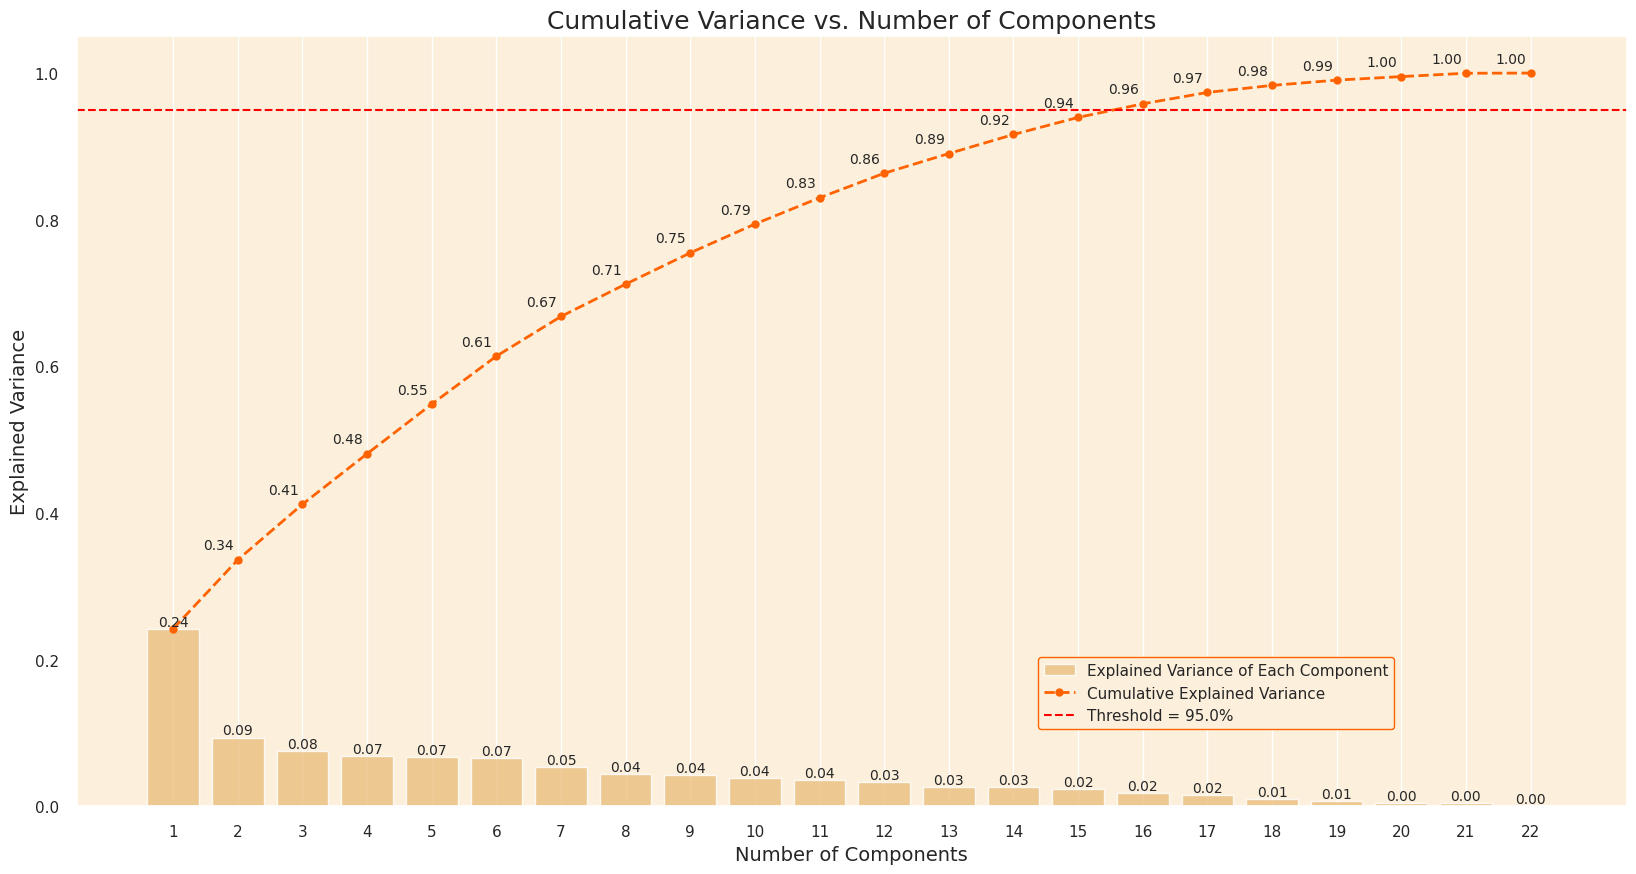

Number of components to reach 95.0% cumulative explained variance: 16


In [ ]:
# Setting CustomerID as the index column
pd_kmeans_scaled_topca=pd_kmeans_scaled.drop(['ville'], axis=1)
pd_kmeans_scaled_topca.set_index('numero', inplace=True)

# Apply PCA
pca = PCA().fit(pd_kmeans_scaled_topca)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# # Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Set a threshold for cumulative explained variance (e.g., 95%)
threshold = 0.95

# Find the number of components that meet the threshold
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot a vertical line at the chosen threshold
threshold_line = plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold * 100}%')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, threshold_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Threshold = {threshold * 100}%'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

# Display the number of components needed to reach the threshold
print(f'Number of components to reach {threshold * 100}% cumulative explained variance: {num_components}')


##### Application de l'ACP

In [ ]:
from sklearn.decomposition import PCA

def apply_pca(dataframe, n_components):
    """
    Apply Principal Component Analysis (PCA) to the given dataframe.

    Parameters:
    - dataframe: The input dataframe.
    - n_components: The number of principal components to retain.

    Returns:
    - pca_dataframe: The dataframe with PCA-transformed features.
    """
    new_columns=dataframe.columns.difference(['ville'])
    new_dataframe= dataframe[new_columns]
    # Creating a PCA object with specified components
    pca = PCA(n_components=n_components)

    # Fitting and transforming the original data to the new PCA dataframe
    pca_dataframe = pca.fit_transform(new_dataframe)

    # Creating a new dataframe from the PCA dataframe
    pca_dataframe = pd.DataFrame(pca_dataframe, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    # Adding the index back to the new PCA dataframe
    pca_dataframe.index = dataframe.index

    return pca_dataframe

# Usage example:
pd_kmeans_pca = apply_pca(pd_kmeans_encoded_loaded, n_components=6)
pd_kmeans_scaled_pca = apply_pca(pd_kmeans_scaled, n_components=6)
pca_columns=pd_kmeans_pca.columns
pd_kmeans_pca.head()


,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.084940e+08,8.398586e+06,-191344.772268,89035.062163,1855.097994,-1050.833905
1,-1.083751e+08,6.477156e+06,-69199.505627,11448.245242,-6343.381068,2869.602179
2,-1.085112e+08,6.476164e+06,-200848.710442,96130.754750,3399.324082,-794.135637
3,-1.084941e+08,6.476052e+06,-170300.923967,84693.831268,1373.476371,-902.672889
4,-1.083751e+08,6.476954e+06,-26110.647583,14164.008907,-6973.088874,2120.279885


In [ ]:
# #Now, let's extract the coefficients corresponding to each principal component to better understand the transformation performed by PCA

# # Define a function to highlight the top 3 absolute values in each column of a dataframe
# def highlight_top3(column):
#     top3 = column.abs().nlargest(3).index
#     return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# # Create the PCA component DataFrame and apply the highlighting function
# pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
#                      index=pd_kmeans_scaled.columns)

# pc_df.style.apply(highlight_top3, axis=0)

#### Nombre de clusters

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


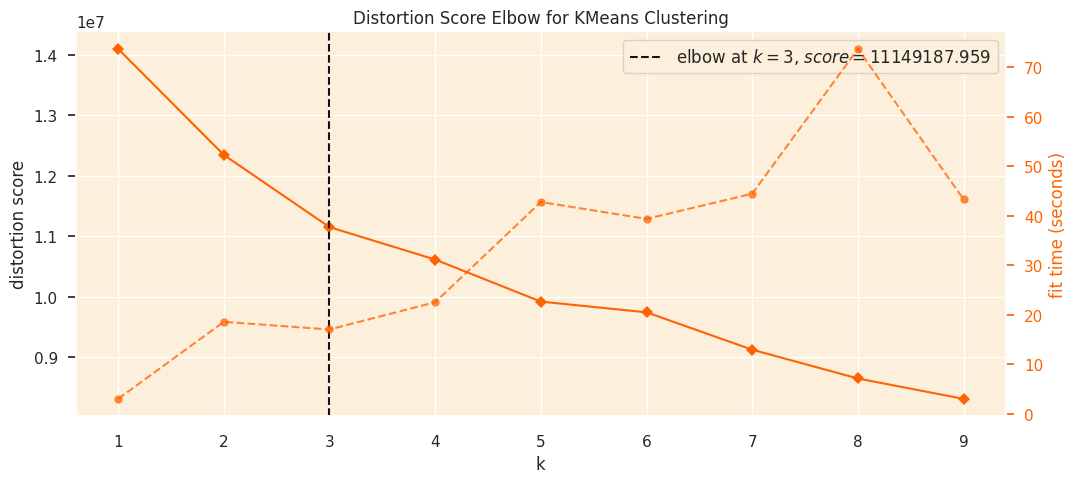

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from pyspark.sql import DataFrame

def visualize_elbow_method(pd_kmeans, feature_columns):
    # Select RFM columns for analysis
    pd_kmeans_features = pd_kmeans[feature_columns]

    # Set plot style, and background color
    sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

    # Set the color palette for the plot
    sns.set_palette(['#ff6200'])

    # Standardize the features
    scaler = StandardScaler()
    kmeans_features_scaled = scaler.fit_transform(pd_kmeans_features)

    # Create an instance of the KElbowVisualizer with explicit n_init
    visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=(1, 10))

    # Create a figure and axis with the desired size
    fig, ax = plt.subplots(figsize=(12, 5))

    # Adjust the model and the visualizer
    visualizer.fit(kmeans_features_scaled)

    # Suppress FutureWarning
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        visualizer.show()


visualize_elbow_method(pd_kmeans_encoded_loaded,km_feature_columns)

#### Entrainement du modele

In [ ]:
import pickle
from sklearn.cluster import KMeans

def train_save_model(dataframe,feature_columns,n_clusters, model_filename):
    # Train KMeans model
    kmeans_model = KMeans(n_clusters=n_clusters, n_init='auto')
    dataframe_cleaned= dataframe[feature_columns]
    kmeans_model.fit(dataframe_cleaned)

    #Save the model to a file using pickle
    with open(model_filename, 'wb') as file:
        pickle.dump(kmeans_model, file)
num_clusters=4
model_path=f'/content/drive/MyDrive/Colab/Segmentation/#models_OM/segment_kmeans_model.pkl'
# train_save_model(pd_kmeans_encoded_loaded,km_feature_columns, num_clusters, model_path)

In [ ]:
def apply_new_labels(model_filename, new_dataframe, feature_columns):

    with open(model_filename, 'rb') as file:
        loaded_kmeans_model = pickle.load(file)
    # Apply new labels to data
    new_labels = loaded_kmeans_model.predict(new_dataframe[feature_columns])

    # Get the frequency of each cluster
    cluster_frequencies = Counter(new_labels)

    # Create a mapping from old labels to new labels
    label_mapping = {old_label: new_label for new_label, (old_label, _) in enumerate(cluster_frequencies.most_common())}

    # Create a new column in the original dataframe with the new labels
    new_dataframe['new_labels'] = [label_mapping[old_label] for old_label in new_labels]

    return new_dataframe['new_labels'].values

def apply_kmeans_clustering(model_filename, new_dataframe, feature_columns=km_feature_columns):
    new_labels = apply_new_labels(model_filename, new_dataframe, feature_columns)

    # Create a new dataframe with the cluster labels
    clustered_dataframe = new_dataframe.copy()  # Use .copy() to avoid unintended modifications
    clustered_dataframe['cluster'] = new_labels

    return clustered_dataframe.drop('new_labels', axis=1)

def apply_kmeans_clustering2(model_filename, new_dataframe, feature_columns=km_feature_columns):
    new_features2 =  apply_new_labels(model_filename, new_dataframe, feature_columns)
    # Create a new dataframe with the cluster labels
    clustered_dataframe2 =new_dataframe.copy()  # Use .copy() to avoid unintended modifications
    clustered_dataframe2['cluster'] = new_features2
    return clustered_dataframe2.drop('new_labels', axis=1)

#Sans normalisation:
pd_segment_valeur = apply_kmeans_clustering(model_path, pd_kmeans_encoded_loaded)

#Normalisation
# pd_segment_valeur_scaled= apply_kmeans_clustering(model_path,pd_kmeans_scaled)
# pd_segment_valeur_scaled2 = apply_kmeans_clustering2(pd_kmeans_scaled,pd_kmeans_encoded_loaded, num_clusters)

# #PCA
# pd_segment_valeur_pca = apply_kmeans_clustering(model_path,pd_kmeans_pca)
# pd_segment_valeur_pca2 = apply_kmeans_clustering2(pd_kmeans_pca,pd_kmeans_encoded_loaded,num_clusters,feature_columns= pca_columns)

#PCA et normalisation
# pd_segment_valeur_scaled_pca = apply_kmeans_clustering(model_path,pd_kmeans_scaled_pca)
# pd_segment_valeur_scaled_pca2 = apply_kmeans_clustering2(pd_kmeans_scaled_pca,pd_kmeans_encoded_loaded, num_clusters, feature_columns=pca_columns)

In [ ]:
pd_segment_valeur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640619 entries, 0 to 640618
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   numero                       640619 non-null  int64  
 1   anciennete                   640619 non-null  int64  
 2   age                          640619 non-null  int64  
 3   ville                        640619 non-null  object 
 4   recence                      640619 non-null  int64  
 5   frequence_total              640619 non-null  int64  
 6   montant_total                640619 non-null  float64
 7   nombre_destinataires         640619 non-null  int64  
 8   nombre_receptions            640619 non-null  int64  
 9   nombre_expediteurs           640619 non-null  int64  
 10  palier_inf                   640619 non-null  float64
 11  palier_sup                   640619 non-null  float64
 12  latest_avg_montant_recharge  640619 non-null  float64
 13 

#### Métrique d'évaluation

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tabulate import tabulate

def compute_clustering_metrics(dataframe,columns_to_drop=['cluster', 'ville']):
    """
    Compute clustering metrics for a given dataframe with cluster labels.

    Parameters:
    - dataframe: The input dataframe with cluster labels.

    Returns:
    - None (prints the metrics table).
    """
    # Compute number of customers
    num_observations = len(dataframe)

    # Separate the features and the cluster labels
    X = dataframe.drop(columns_to_drop, axis=1)
    clusters = dataframe['cluster']

    # Compute the metrics
    sil_score = silhouette_score(X, clusters)
    calinski_score = calinski_harabasz_score(X, clusters)
    # davies_score = davies_bouldin_score(X, clusters)

    # Create a table to display the metrics and the number of observations
    table_data = [
        # ["Nombre d'observations", num_observations],
        ["Silhouette Score", sil_score],
        ["Calinski Harabasz Score", calinski_score],
        # ["Davies Bouldin Score", davies_score]
        ]

    # Print the table
    print(tabulate(table_data, headers=["Métrique", "Valeur"], tablefmt='grid'))

# # Usage example
print(f"Le nombre de clusters: {num_clusters}")
print("Sans normalisation")
compute_clustering_metrics(pd_segment_valeur)

# print("\n\nAvec PCA")
# compute_clustering_metrics(pd_segment_valeur_pca,['cluster'])

# print("\n\nAvec normalisation")
# compute_clustering_metrics(pd_segment_valeur_scaled)

# print("\n\nAvec normalisation et PCA")
# compute_clustering_metrics(pd_segment_valeur_scaled_pca,['cluster'])

Le nombre de clusters: 4
Sans normalisation
+-------------------------+-------------+
| Métrique                |      Valeur |
+=========================+=============+
| Silhouette Score        | 0.0500902   |
+-------------------------+-------------+
| Calinski Harabasz Score | 1.14216e+10 |
+-------------------------+-------------+


####  Profilage  (Tendances centrales)

##### Approche Radar

In [ ]:
def plot_radar_chart(dataframe):
    """
    Plot radar charts for each cluster using the centroid values.

    Parameters:
    - dataframe: The input dataframe with cluster labels.
    - colors: List of colors for the clusters.

    Returns:
    - None (displays the radar charts).
    """

    new_columns=dataframe.columns.difference(['ville'])
    new_dataframe= dataframe[new_columns]
    # Set 'CustomerID' column as index and assign it to a new dataframe
    df_customer = new_dataframe.set_index('numero')

    colors=[ '#1ac938','orange', '#e8000b', '#023eff', 'black']  # Add a color for the 5th cluster

    # Standardize the data (excluding the cluster column)
    scaler = StandardScaler()
    df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

    # Create a new dataframe with standardized values and add the cluster column back
    df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
    df_customer_standardized['cluster'] = df_customer['cluster']

    # Calculate the centroids of each cluster
    cluster_centroids = df_customer_standardized.groupby('cluster').mean()

    # Function to create a radar chart
    def create_radar_chart(ax, angles, data, color, cluster):
        # Plot the data and fill the area
        ax.fill(angles, data, color=color, alpha=0.4)
        ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

        # Add a title
        ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

    # Set data
    labels = np.array(cluster_centroids.columns)
    num_vars = len(labels)

    # Compute angle of each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is circular, so we need to "complete the loop" and append the start to the end
    labels = np.concatenate((labels, [labels[0]]))
    angles += angles[:1]

    # Get the number of clusters dynamically
    num_clusters = len(cluster_centroids)

    # Initialize the figure
    fig, ax = plt.subplots(figsize=(50, 30), subplot_kw=dict(polar=True), nrows=1, ncols=num_clusters)

    # Create radar chart for each cluster
    for i, color in enumerate(colors[:num_clusters]):  # Use only the required number of colors
        data = cluster_centroids.loc[i].tolist()
        data += data[:1]  # Complete the loop
        create_radar_chart(ax[i], angles, data, color, i)

    # Add input data
    for a in ax:
        a.set_xticks(angles[:-1])
        a.set_xticklabels(labels[:-1])

    # Add a grid
    for a in ax:
        a.grid(color='grey', linewidth=0.5)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Usage example
print(f"Le nombre de clusters: {num_clusters}")
print("Sans normalisation")
plot_radar_chart(pd_segment_valeur)

# print("\n\nAvec PCA")
# plot_radar_chart(pd_segment_valeur_pca2)

# print("\n\nAvec normalisation")
# plot_radar_chart(pd_segment_valeur_scaled2)

# print("\n\nAvec normalisation et PCA")
# plot_radar_chart(pd_segment_valeur_scaled_pca2)

##### Approche Histogramme

In [ ]:
def plot_cluster_distribution(dataframe, colonne, cluster):
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.set(style="whitegrid")
    data = dataframe[dataframe['cluster'] == cluster]
    custom_palette = sns.color_palette("husl")

    sns.histplot(x=colonne, data=data, palette=custom_palette, bins=20, kde=False)

    total_count = len(data)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    ax.set_ylabel('Nombre de clients')
    ax.set_title(f"Répartition des clients par {colonne}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='both', labelsize=14)

    plt.show()

# Utilisation avec un histogramme
plot_cluster_distribution(pd_segment_valeur, 'nombre_receptions', 3)


In [ ]:
def plot_cluster_histograms(data, feature_columns):
    """
    Plot histograms for each feature segmented by the clusters.

    Parameters:
    - data: DataFrame containing the data.
    - feature_columns: List of feature column names.
    - cluster_column: Name of the column containing cluster labels.
    - bins: Number of bins for the histograms.
    - colors: List of colors for each cluster.

    Returns:
    - None
    """

    colors=[ '#1ac938','orange', '#e8000b', '#023eff', 'black']
    cluster_column='cluster'
    clusters = data[cluster_column].unique()
    clusters.sort()

    # Setting up the subplots
    n_rows = len(feature_columns)
    n_cols = len(clusters)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))

    # Plotting histograms
    for i, feature in enumerate(feature_columns):
        for j, cluster in enumerate(clusters):
            cluster_data = data[data[cluster_column] == cluster][feature]
            axes[i, j].hist(cluster_data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
            axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
            axes[i, j].set_xlabel('')
            axes[i, j].set_ylabel('')

    # Adjusting layout to prevent overlapping
    plt.tight_layout()
    plt.show()

print("Sans normalisation")
plot_cluster_histograms(pd_segment_valeur, km_feature_columns)

# print("\n\nAvec normalisation")
# plot_cluster_histograms(pd_segment_valeur_scaled, km_feature_columns)

# print("\n\nAvec PCA")
# plot_cluster_histograms(pd_segment_valeur_pca, km_feature_columns)

# print("\n\nAvec normalisation et PCA")
# plot_cluster_histograms(pd_segment_valeur_scaled_pca, km_feature_columns)


##### Profils

- **Cluster 0**:
1.Montant_service_achat, montant_service_paiement, nombre_service, frequence_service, frequence_servie_achat
- **Cluster 1**:
1.Palier_sup

2.Lastest_avg_montant_recharge, frequence_total, montant_total, recence, anciennete

3.Frequence_service_financier
- **Cluster 2**
1.Palier_inf, montant_service_paiement, montant_service_achat

2.Frequence_service_achat,frequence_service_paiement,nombre_services,montant_service_paiement,montant_service_acaht

- **Cluster 3**
1.Montant_service_achat, montant_service_paiement

3.Frequence_service_paiement, frequence_service_achat

- **Cluster 4**
1.Palier_inf

2.Nombre_services

In [ ]:
def profiler_segmented_dataframe(original_dataframe, segment_labels):
    # Créer une copie du DataFrame existant
    df_final = original_dataframe.copy()

    # Ajouter la colonne 'segment' avec les valeurs correspondantes
    df_final['segment'] = df_final['cluster'].map(segment_labels).fillna('Autre')

    return df_final


# num_clusters = 4
# pd_segment_valeur = apply_kmeans_clustering(pd_kmeans_encoded_loaded, num_clusters)

segment_labels2 = {
    0: 'Dispersé',
    1: 'Polyvalent multiservice',
    2: 'Dépensier',
    3: 'Acheteur de produits Orange et payeur de factures',

}

# # Utiliser la fonction pour créer le nouveau DataFrame
pd_segment_valeur_final = profiler_segmented_dataframe(pd_segment_valeur, segment_labels2)



In [ ]:
# # Display the filtered DataFrame
pd.set_option('display.max_columns', None)
pd_segment_valeur_final[pd_segment_valeur_final["cluster"] == 1].head(1000)

In [ ]:
segment_valeur_final_df =pd_segment_valeur_final[pd_segment_valeur_final["numero"] == '1000001' ]
segment_valeur_final_df

In [ ]:
filtered_list = [item for item in pd_segment_valeur_final_dict if item.get("numero") == 1000708]
filtered_list

#### Visualisation des segments

##### Description des clusters

In [ ]:
import pandas as pd

tableau = {
    'Clusters': [0,1,2,3],

    'Profils': [
    'Polyvalent ',
     'Client valeureux et rechargeur',
    'Dépensier',
     'Acheteur de produits Orange et payeur de factures'
],

    'Activités': [

            ]
}

df = pd.DataFrame(tableau)

# Centrer le texte dans la colonne 'Activité' et changer la couleur en bleu et blanc
def highlight_text(text):
    return f'text-align: center;'

styled_df = df.style.applymap(highlight_text)

# Add borders between columns
styled_df.set_properties(**{
    'border': '1px solid white',
    'border-collapse': 'collapse',
    'text-align': 'center'
})


In [ ]:
import pandas as pd

tableau = {
    'Clusters': [0, 1, 2, 3],

    'Profils': [
        'Dispersé',
        'Polyvalent multiservice',
        'Dépensier',
        'Acheteur de produits Orange et payeur de factures',
    ],

    'Activités': [
        'Clients à profil dispersé ayant des caractéristiques communes',
        'Gèrent leurs finances avec prudence, effectuent des transactions étendues et sont actifs dans les recharges.',
        'Dépensent de manière significative, en particulier dans des services financiers variés.',
        'Concentrés sur l\'achat de produits Orange et le paiement de factures.',
    ]
}

df = pd.DataFrame(tableau)

# Centrer le texte dans la colonne 'Activité' et changer la couleur en bleu et blanc
def highlight_text(text):
    return f'text-align: center;'

styled_df = df.style.applymap(highlight_text)

# Add borders between columns
styled_df.set_properties(**{
    'border': '1px solid white',
    'border-collapse': 'collapse',
    'text-align': 'center'
})


,Clusters,Profils,Activités
0,0,Dispersé,Clients à profil dispersé ayant des caractéristiques communes
1,1,Polyvalent multiservice,"Gèrent leurs finances avec prudence, effectuent des transactions étendues et sont actifs dans les recharges."
2,2,Dépensier,"Dépensent de manière significative, en particulier dans des services financiers variés."
3,3,Acheteur de produits Orange et payeur de factures,Concentrés sur l'achat de produits Orange et le paiement de factures.


##### Répartion des clients

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_segment_distribution_by_customer(dataframe, segment_column):
    # Create a countplot with a custom color palette
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.set(style="whitegrid")

    custom_palette =['#1ac938', 'orange', '#e8000b', '#023eff', 'black']

    sns.countplot(x=segment_column, data=dataframe, palette=custom_palette)

    # Calculate the total number of customers
    total_count = len(dataframe)

    # Annotate bars with percentages
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    # Modify the ylabel and title
    ax.set_ylabel('Nombre de clients')
    ax.set_title('Distribution des clients par segment')

    # Rotate x-axis labels by 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Increase font size
    ax.tick_params(axis='both', labelsize=14)

    plt.show()

# Example usage:
# Assuming pd_rfm_segments is your DataFrame and 'segment_RFM' is the segment column
# Replace these values with your actual DataFrame and column names
plot_segment_distribution_by_customer(pd_segment_valeur_final, 'segment')


NameError: name 'pd_segment_valeur_final' is not defined

In [ ]:
pd_segment_valeur_final.info()

NameError: name 'pd_segment_valeur_final' is not defined

##### Répartition du chiffre d'affaires

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution_by_segment(dataframe, x_column, y_column):
    # Group by the specified segment column and calculate total revenue
    grouped_data = dataframe.groupby(x_column)[y_column].sum().reset_index()

    # Calculate the percentage of revenue for each segment
    total_revenue = grouped_data[y_column].sum()
    grouped_data['Percentage_Revenue'] = (grouped_data[y_column] / total_revenue) * 100

    # Create a diverse color palette
    diverse_palette = sns.color_palette("husl", n_colors=len(grouped_data))

    # Create a bar plot using the diverse color palette
    fig, ax = plt.subplots(figsize=(20, 9))
    ax.bar(grouped_data.index, grouped_data['Percentage_Revenue'], color=diverse_palette)
    ax.set_xlabel('Segments')
    ax.set_ylabel(f'Pourcentage du revenu')
    ax.set_title('Pourcentage du revenu par segment')

    # Customize x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xticks(grouped_data.index)
    ax.set_xticklabels(grouped_data[x_column])

    # Annotate bars with percentages
    for i, percentage in enumerate(grouped_data['Percentage_Revenue']):
        ax.annotate(f'{percentage:.2f}%', (grouped_data.index[i], percentage), ha='center', va='bottom')

    plt.show()

# Example usage:
# Assuming pd_rfm_segments is your DataFrame, 'segment_RFM' is the segment column, and 'montant' is the revenue column
# Replace these values with your actual DataFrame and column names
plot_distribution_by_segment(pd_segment_valeur_final, 'segment','montant_total')

In [ ]:
plot_distribution_by_segment(pd_segment_valeur_final, 'segment','frequence_total')

#### Répartition par ancienneté/age

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_age_distribution_by_rfm_segment(dataframe, segment_column, age_column):
#     # Create a new 'AgeGroup' column to group customers by 10-year age brackets
#     dataframe['AgeGroup'] = (dataframe[age_column] // 10) * 10

#     # Group the data by RFM segment and age group, then calculate percentages by multiplying by 100
#     grouped_data = dataframe.groupby([segment_column, 'AgeGroup']).size().unstack().div(dataframe.groupby(segment_column).size(), axis=0) * 100

#     # Retrieve age group labels
#     age_labels = [f'{i}' for i in range(10, 100, 10)]

#     # Add '%' sign to annotations
#     annot_data = grouped_data.applymap(lambda x: f'{x:.0f}%')

#     # Display the distribution table with percentages in percentage (%)
#     plt.figure(figsize=(14, 8))
#     sns.heatmap(grouped_data, annot=annot_data, cmap='YlGnBu', cbar=False, fmt='', linewidths=1, linecolor='black')
#     plt.title("Customer Distribution by RFM Segment and Age Group (in percentage)")
#     plt.xlabel("Age Group")
#     plt.ylabel("RFM Segment")

#     # Move age group labels to the center
#     plt.xticks(range(len(age_labels)), age_labels, rotation=0)

#     # Move age group labels 0.5 units down
#     plt.yticks(range(len(grouped_data.index)), grouped_data.index, va="center")

#     plt.show()

# # Example usage:
# # Assuming pd_rfm_joined is your DataFrame, 'segment_RFM' is the segment column, and 'age' is the age column
# # Replace these values with your actual DataFrame and column names
# plot_age_distribution_by_rfm_segment(pd_segment_valeur_final, 'segment', 'age')


# **TESTS**

---



In [ ]:
# #Importation des CSV
# path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'
# file_list=['2022_2.csv', '2022_3.csv','2022_4.csv','2022_5.csv','2022_6.csv','2022_7.csv',  '2022_8.csv', '2022_8.csv','2022_9.csv','2022_10.csv','2022_11.csv','2022_12.csv','2023_1.csv','2023_2.csv','2023_3.csv','2023_4.csv','2023_5.csv','2023_6.csv','2023_7.csv', ]
# df_agg = spark.read.csv(f'{path}/2022_1.csv', header=True)
# for csv_file in file_list:
#   df = spark.read.csv(f'{path}/{csv_file}', header=True, inferSchema=True)
#   df_agg = df_agg.union(df)

# df_agg.write.csv('#datasets_OM/trusted_om.base_transaction.csv', header=True, mode='overwrite')
# # df_agg.toPandas().to_csv('#datasets_OM/trusted_om.transactions.csv', index=False)
# # Show the RFM DataFrame
# df_agg.show()

In [ ]:
#!git clone https://github.com/asish012/dataanalytics.git

In [ ]:
# http://localhost:5000/segment_multiservice?numero_client=1000263&date_debut=2022-01-02&date_fin=2023-08-14

https://teams.microsoft.com/l/meetup-join/19%3ameeting_OTM5MTU4ZjgtZWRhMi00OGNmLThjNWUtODdkODk3MjNjZjNm%40thread.v2/0?context=%7b%22Tid%22%3a%22c1d47378-a976-412f-946f-f443471c31d8%22%2c%22Oid%22%3a%229b159804-21d5-4c36-93b7-035cfb264459%22%7d